### Knowledge Graphs + Code + LLMs

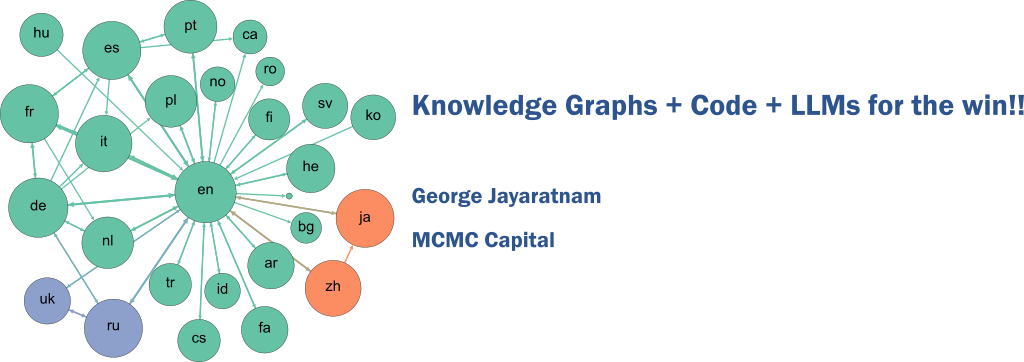

In [1]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/title.png"

# Display the PNG file
Image(filename=png_path)

### Summary

**The problem:** How to understand / piece together a large unfamiliar codebase when there is:


- Missing, scant, and sometimes inaccurate documentation
 

- Mixed use of technologies and frameworks + legacy code


- No easy way of tracking connected files, function, parameters, etc.


- No natural language explanation of code blocks
  

**The solution:** This notebook shows how to use a knowledge graph to analyse
 connected data like a large codebase.
  

Key features:
 
 
- Works primarily with metadata


- Ingest metadata into the graph quickly and start asking questions


- As more questions are triggered, the graph is progressively enhanced


- LLMs are used to help with an initial 'understanding' of what the code does


- Control over the input token limits of the LLM are managed via graph queries

 
- Demo is based on the Zotero app teardown but approach is generalisable to any 
codebase irrespective of size, language, tech stack, etc.

### Notebook summary: LLMs + Knowledge Graphs + Code

1. Knowledge graph (KG) basics
    - Basic concepts
    - Storage options


2. My use case: Improving Zotero's search capability
    - Hacking a complex codebase!
    - Knowledge graph design 


3. Part 1: A KG for the data layer
    - What are my questions
    - Buildling a knowledge graph on top of a RDBMS


4. Part 2: A KG for the application layer
    - Abstract Syntax Trees (AST)
    - Working with the Github Search API
    - LLMs to help with ***initial*** code explanations


5. Part 3: A KG for the business domain layer
    - GraphRAG for text
    - Public ontologies

   
6. Key takeways + Resources

### The big picture

###### Diagram: What I'm trying to build

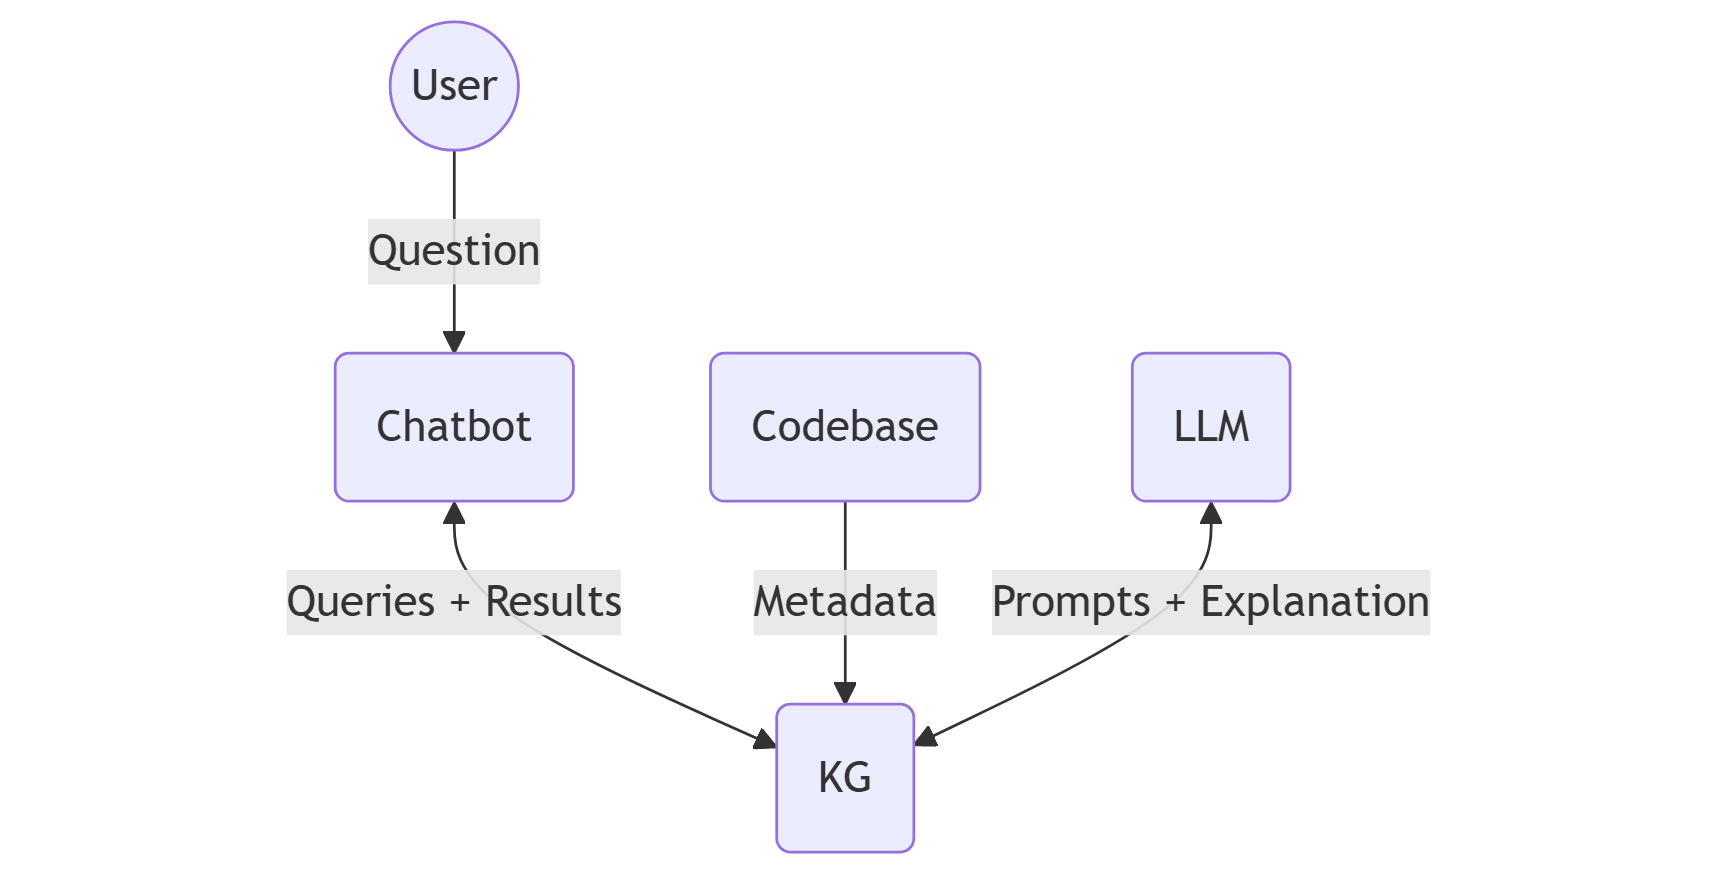

In [7]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/bigPicture.png"

# Display the PNG file
Image(filename=png_path)

This knowledge graph demo is designed to be a federation of 3 separate 
knowledge graphs:
1. Data KG (Part 1) - database schemas
2. Application KG (Part 2) - application code
3. Business Domain KG (Part 3) - text in the form of ontologies

Each KG ingests metadata from different sources and caters to questions 
about their respective layer. 

###### Diagram: Code Overview - creating the Data and Application KGs

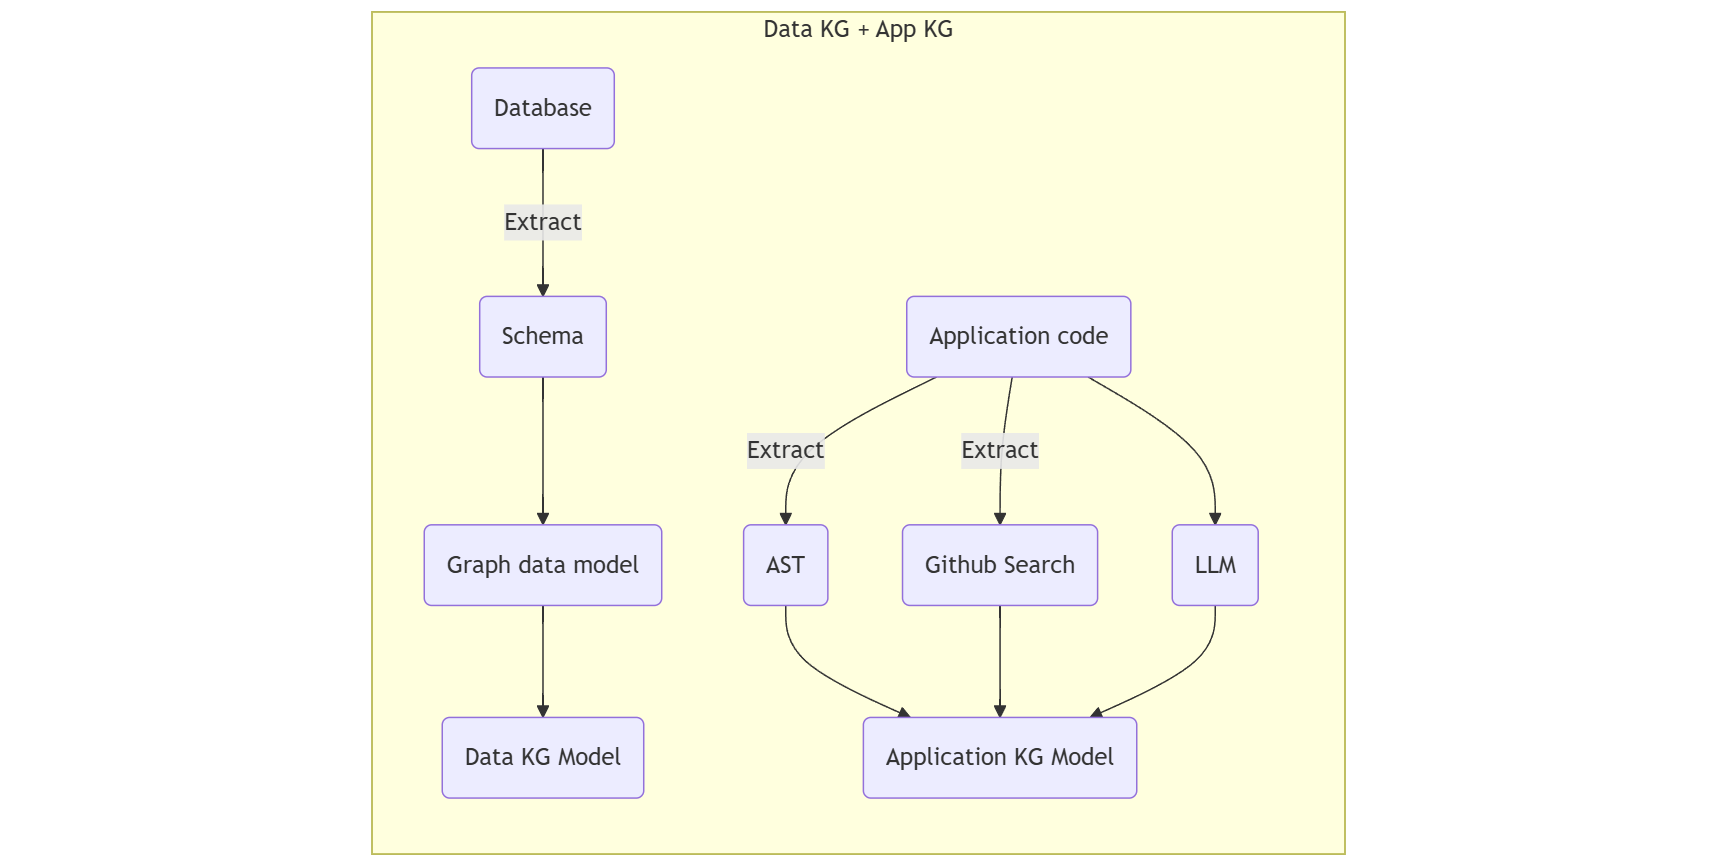

In [13]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/codeOverview.png"

# Display the PNG file
Image(filename=png_path)

###### Diagram: Unstructured data - creating the Business Domain KGs

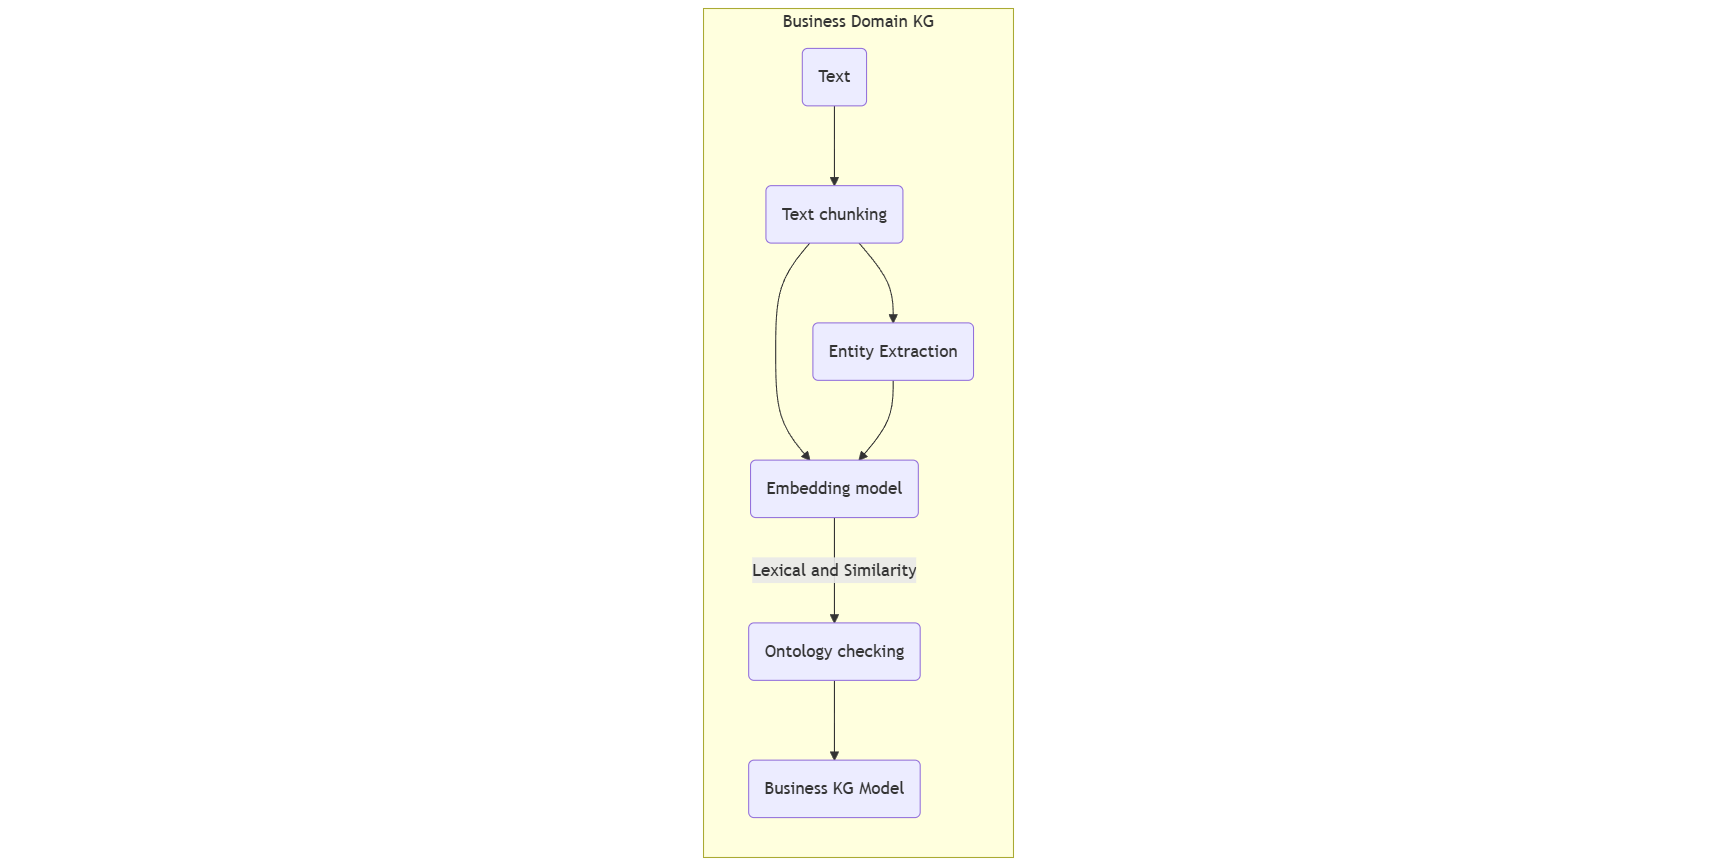

In [14]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/textOverview.png"

# Display the PNG file
Image(filename=png_path)

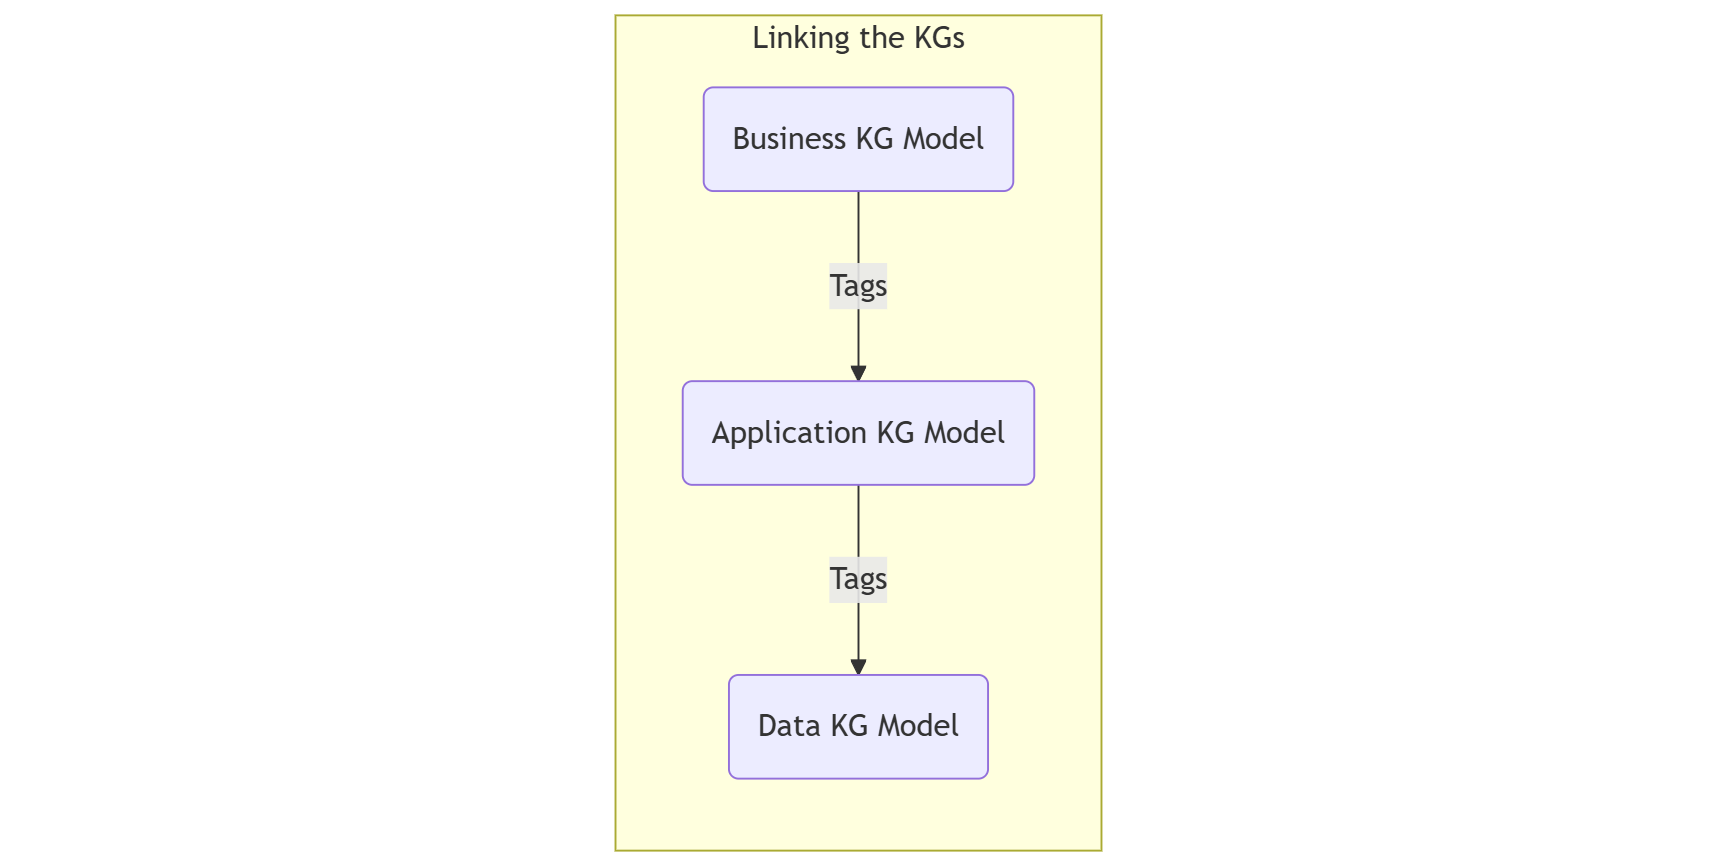

In [17]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/combined.png"

# Display the PNG file
Image(filename=png_path)

*Diagrams inspired by the work of [Paco Nathan](https://www.youtube.com/watch?v=B6_NfvQL-BE), a KG industry guru*

### 1. Knowledge graph (KG) 

###### What are knowledge graphs?

> "Knowledge graphs are a way of organizing and representing information in a machine-readable format. A knowledge graph represents a collection of real-world concepts (displayed as nodes) and relationships (displayed as edges) in the form of a graph used to link and integrate data coming from diverse sources."
> 
> `-` [data.world](https://data.world/blog/what-is-a-knowledge-graph/)


*My take* - Just a way of representing knowledge to:


1. Answer questions - given context


2. Able to be read by machines/code


3. Is accurate - logical and traceable


4. Easily updatable - new learning/refactor

#### Storage options

Many ways to store a knowledge graph:


1. Graph databases

   1. Neo4j
         
   2. Janus (open source)

   3. TigerGraph

    
2. RDF triplestores

   1. Blazegraph (Wikipedia)
   
   2. GraphDB (Ontotext)
     
   3. PoolParty


3. Elasticsearch - requires plugins


4. RDBMS - MySQL at Facebook (2004)  

#### Neo4j example 

- Graph example from Neo4j


- Data from the 
[StackOverflow Questions API](https://neo4j.com/graphgists/1a1d669d-8f35-485c-afe7-b4e0bf45d7d7/)


- Ingested into a Neo4j graph model

#### Neo4J - Why I ended up choosing them

- Build my own PageRank for contextual text search


- Started with Elasticsearch


- Neo4j easiest to get onboarded


- Free local and cloud options


- Query syntax (Cypher) similar to SQL


- Cypher moving to W3C standard - can work with other compliant graph DBs 
(SAP HANA 
Graph)

#### Neo4j example 

- Graph example from Neo4j


- Data from the 
[StackOverflow Questions API](https://neo4j.com/graphgists/1a1d669d-8f35-485c-afe7-b4e0bf45d7d7/)


- Ingested into a Neo4j graph model

###### Code: Setup environment and cypher query function

In [1]:
# Setup env and key query function
from dotenv import load_dotenv
from neo4j import GraphDatabase
import sqlite3
from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
import os
import pandas as pd
import requests
import time
import base64
import subprocess
import json
import pickle
import datetime
import pytz
import re
import ast
from pathlib import Path
from langchain_openai import ChatOpenAI
from langchain_neo4j import Neo4jGraph, GraphCypherQAChain
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate, ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
import gradio as gr

load_dotenv()

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
UN = os.getenv("NEO4J_USERNAME")
PW = os.getenv("NEO4J_PASSWORD")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")


# Define a function to run a Cypher query   
def run_cypher_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters)
        # Fetch and return the results
        return result.data()

###### Code: Stackoverflow graph schema: View, Nodes, Counts

In [2]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='stackoverflow') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

    # Query to list all nodes and their properties
    query_stack_nodes = """
    CALL db.schema.nodeTypeProperties() 
    YIELD nodeType, propertyName 
    RETURN nodeType AS label, COLLECT(propertyName) AS properties
    """
    result_query_stack_nodes = run_cypher_query(query_stack_nodes)
    df_result_query_stack_nodes = pd.DataFrame(result_query_stack_nodes)
    print(f"Results: query_stack_nodes\n{df_result_query_stack_nodes}\n")

    # Query to print a sample of 5 records from the Tag node
    query_tag_sample = """
    MATCH (t:Tag)  
    RETURN t AS tag_props 
    LIMIT 5;
    """
    result_query_tag_sample = run_cypher_query(query_tag_sample)
    df_result_query_tag_sample = pd.DataFrame(result_query_tag_sample)
    print(f"Results: query_tag_sample\n{df_result_query_tag_sample}\n")

    # Query to count the frequency of nodes
    query_stack = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """

    result_stack = run_cypher_query(query_stack)
    df_stack_nodes = pd.DataFrame(result_stack)
    # Flatten the 'label' column since it's a list
    df_stack_nodes['label'] = df_stack_nodes['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print(f"Results: df_stack_nodes['label']\n{df_stack_nodes}\n")  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Results: query_stack_nodes
         label                                         properties
0      :`User`                               [uuid, display_name]
1       :`Tag`                                       [name, link]
2    :`Answer`  [uuid, title, link, is_accepted, body_markdown...
3   :`Comment`                                [uuid, link, score]
4  :`Question`  [uuid, title, creation_date, accepted_answer_i...

Results: query_tag_sample
                                           tag_props
0  {'name': 'neo4j', 'link': 'https://stackoverfl...
1  {'name': 'subgraph', 'link': 'https://stackove...
2  {'name': 'graph', 'link': 'https://stackoverfl...
3  {'name': 'cypher', 'link': 'https://stackoverf...
4  {'name': 'graph-databases', 'link': 'https://s...

Results: df_stack_nodes['label']
      label  count
0  Question   1589
1   Comment   1396
2    Answer   1367
3      User   1365
4       Tag    476



###### Diagram: Stackoverflow schema - from code result

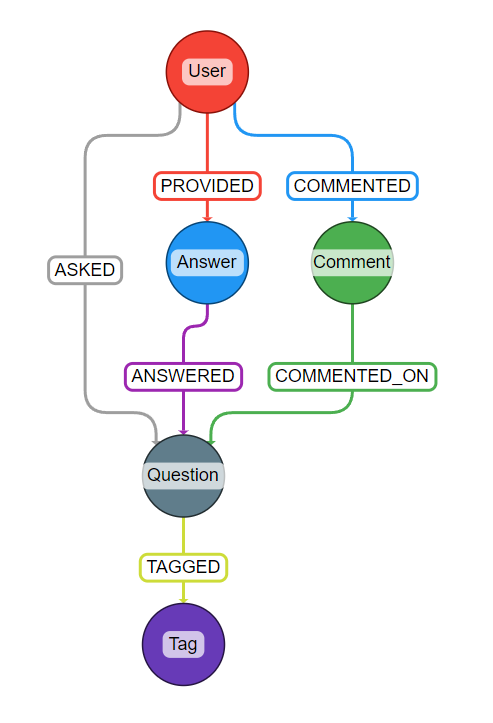

In [3]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/stackoverflow_schema.png"

# Display the PNG file
Image(filename=png_path)

So what types of questions can we answer from this schema?


**Question: "How are tags related to other tags?"**


```
    MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
    WHERE t1.name < t2.name AND t1.name <> 'neo4j' AND t2.name <> 'neo4j'
    RETURN t1.name AS TAG_1, t2.name AS TAG_2 , count(*) AS freq
    ORDER BY freq DESC LIMIT 10;
```


* Each tag is a unique instance of the `Tag` node 


Answer **requires multiple joins** via the Question Node.

###### Code: Query to calculate the frequency of the top 10 tag-pairs

In [11]:
# import pandas as pd
# from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget

with GraphDatabase.driver(URI, auth=AUTH, database='stackoverflow') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # Question: "How are tags related to other tags"
    query_tags = """
    MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
    WHERE t1.name < t2.name AND t1.name <> 'neo4j' AND t2.name <> 'neo4j'
    RETURN t1.name AS TAG_1, t2.name AS TAG_2 , count(*) AS freq
    ORDER BY freq DESC LIMIT 10;
    """

    result_tags = run_cypher_query(query_tags)
    df_result_tags = pd.DataFrame(result_tags)
    # Flatten the 'label' column since it's a list
    # df_result_4['label'] = df_result_4['label'].apply(lambda x: x[0])
    print(f"Tag-pair frequency\n{df_result_tags}\n")  # Outputs the list of tag-pair frequencies

driver.close()

Neo4j connection established.
Tag-pair frequency
    TAG_1            TAG_2  freq
0  cypher       neo4j-apoc    86
1  cypher  graph-databases    79
2  cypher            graph    46
3  cypher           python    32
4  cypher         database    30
5  cypher             java    29
6  cypher       redisgraph    27
7  py2neo           python    20
8  cypher          graphql    17
9    java           spring    17



#### Key points: Representing knowledge in a graph database

1. Both nodes and relationships can have multiple properties - numbers, text,
 dates


2. Two nodes can have multiple relationships between them


3. Graph databases have a schema but they are flexible / easy to refactor


4. Graph schema design depends on the types of questions you want to ask 


5. Suited for questions/queries where the intermediate nodes are not known - 
multi-hop


6. Pre-processing data prior to ingestion may require some effort

### 2. My use case: Improving Zotero's search capability

- Widely used citation and bibliography management tool in the academic and 
research community


- Drag-n-drop content storage (PDF, URLs, Youtube, RSS etc).


- **70+ data connectors**: PDFs, websites, wikis, aggregator sites, news sites 


- Issues with Zotero's search functionality:
    - Manual tagging - no link with ontologies
    - No in-content search - PDFs only if you sync with Zotero Cloud
    - No control over tag weights for search result ranking
    - Tag management


- Want to build my own search ranking engine on top of Zotero data

###### Diagram: What I'm trying to do

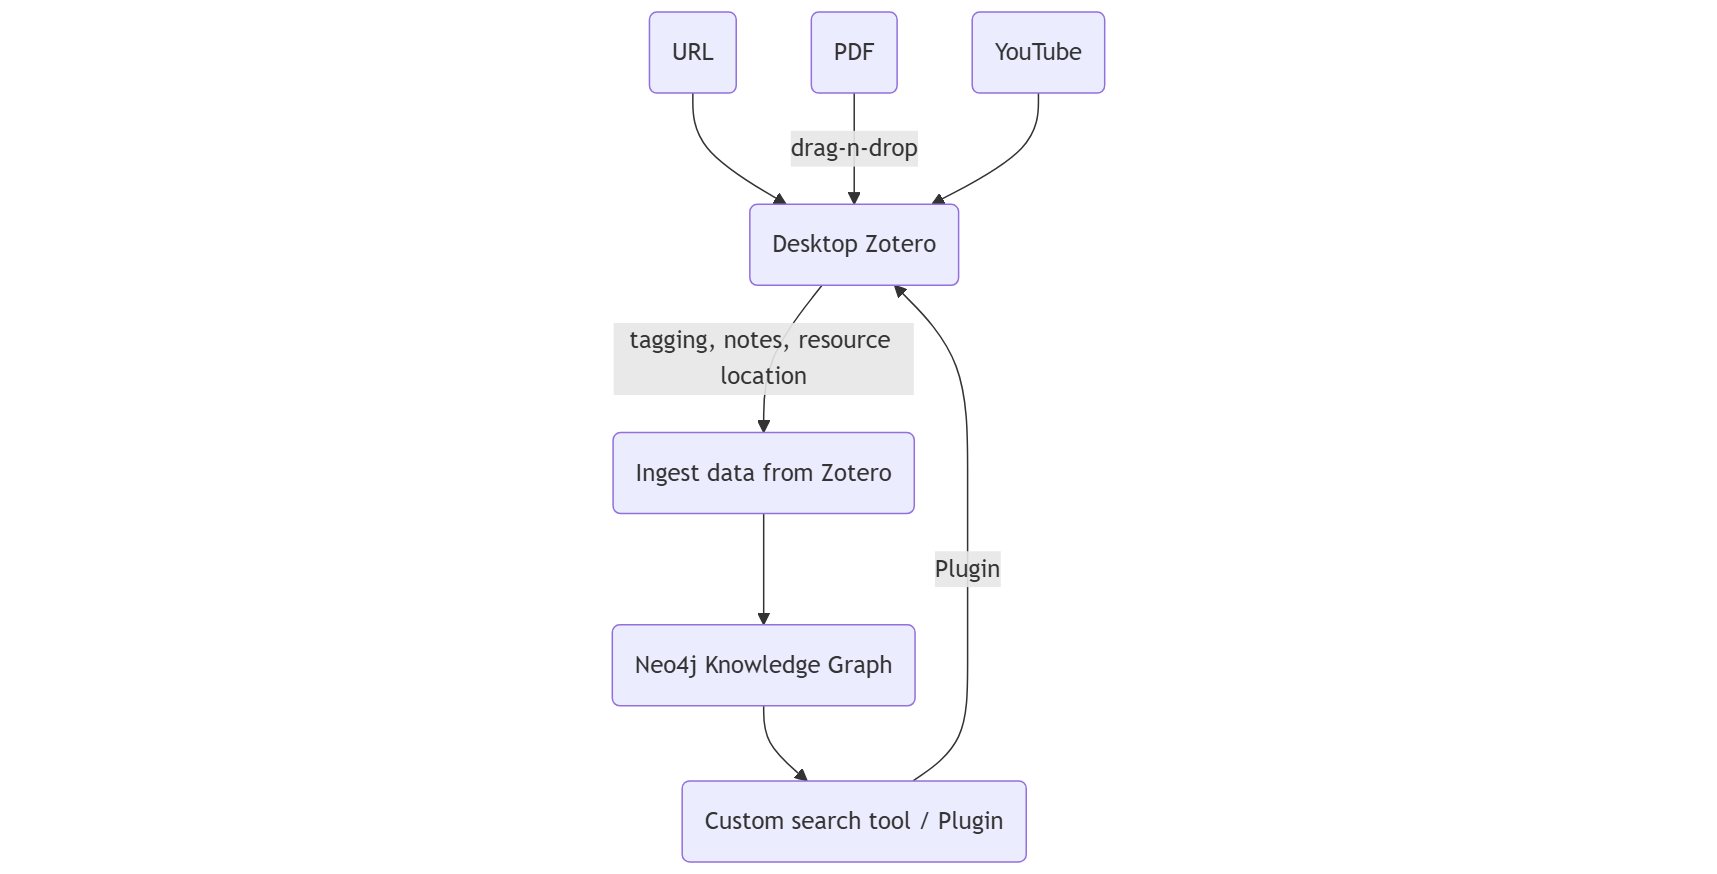

In [88]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/zoteroWorkflow.png"

# Display the PNG file
Image(filename=png_path)

###### Hacking a complex codebase: Can connected data help?

- Zotero's documentation doesn't really explain the codebase


- I need to start from ground-zero


1. What are the basics
    - How and where is the data kept?
    - How does the codebase work - any framework used?


2. How is the codebase connected right across the stack?
    - What does the data model look like?
    - How does the application talk to the database?
    - How do the various classes, functions and parameters relate to each other?  

### 3. Part 1: Building a KG for the data layer

#### When a DBMS is the data store, the schema + stored functions hold the key

- Zotero uses [SQLite](https://www.zotero.org/support/dev/client_coding/direct_sqlite_database_access) as its database


- However content is stored in individual hashed folders in the `Users` directory


- **My question:** How do I go from where the tags in the database to the actual location for each piece of content?


- For that I need to know:

    1. Which table holds the tags
    2. Which table holds the information about the content and its' hashed storage location
    3. **How are the tables connected?**

#### Steps to pre-process and load the SQLite schema and foreign key metadata into Neo4j:


1. Extract table and column names by merging sqlite_master table to PRAGMA 
table_info(table_name)


2. Extract foreign key info from foreign_key_list(table_name)


3. Write a script a `For loop` to run through the `table_name` list and 
output result to a `csv` file


*[Code block not shown]*

###### Diagram: Data pipeline to ingest SQLite metadata into Neo4J

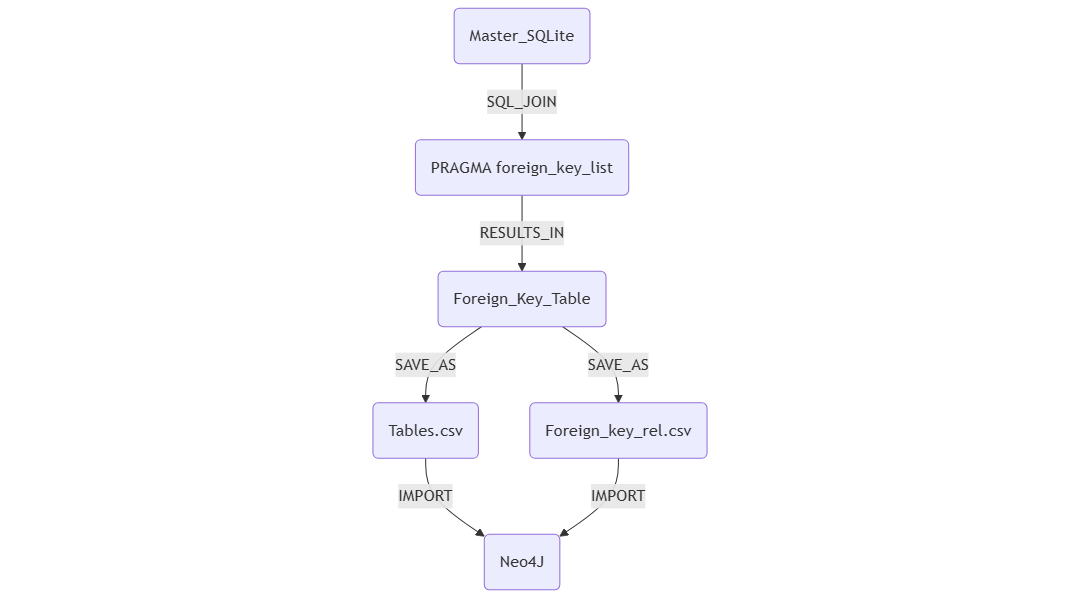

In [18]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/dataKGCodeFlow.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Connect to the db file `zotero.sqlite` for schema queries

###### Code: Check SQLite db connection

In [15]:
# Connect to the SQLite database
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")

    sqlite_select_Query = "select sqlite_version();"
    cursor.execute(sqlite_select_Query)
    record = cursor.fetchall()
    print("SQLite Database Version is: ", record)
    # Close cursor
    cursor.close()

# SQLite connection object will persist if not closed manually:
sqliteConnection.close()

# Check if cursor is still open due:
try:
    cursor.execute('SELECT 1')  # Will raise an error if connection is closed
    print("Cursor still open.")
except sqlite3.ProgrammingError:
    print("Cursor closed.")

# Check if connection is closed:
try:
    sqliteConnection.execute('SELECT 1')  # Will raise an error if connection is closed
    print("Connection still open.")
except sqlite3.ProgrammingError:
    print("SQLite connection is closed.")

Connected to Zotero SQLite
SQLite Database Version is:  [('3.45.3',)]
Cursor closed.
SQLite connection is closed.


###### Code: Extract data dictionary from `sqlite_master` table

In [17]:
# If the Zotero application is open, the database will be locked. Close it first.

# Create new SQLite connection
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")
    cursor.execute('PRAGMA table_info(sqlite_master);')
    columns = [column[1] for column in cursor.fetchall()]
    print(f"List of columns:\n{columns}\n")

    # Frequency count of type column
    query_schema_obj = """
        SELECT type, COUNT(*) AS frequency
        FROM sqlite_master
        GROUP BY type
        
        UNION ALL

        SELECT 'Total', COUNT(*)
        FROM sqlite_master
    """
    df_schema_obj_count = pd.read_sql_query(query_schema_obj, sqliteConnection)
    print(f"Frequency count of schema objects:\n{df_schema_obj_count}\n")

    # Close cursor
    cursor.close()

# Close connection    
sqliteConnection.close()
print("SQLite connection closed")

Connected to Zotero SQLite
List of columns:
['type', 'name', 'tbl_name', 'rootpage', 'sql']

Frequency count of schema objects:
      type  frequency
0    index         84
1    table         61
2  trigger         12
3    Total        157

SQLite connection closed


###### Code: Query (Neo4j) to view schema, count nodes

In [19]:
with GraphDatabase.driver(URI, auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # Query to count nodes and relationships in Neo4j
    query_sqlite_nodes = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """
    result_query_sqlite_nodes = run_cypher_query(query_sqlite_nodes)
    # Convert the list of dictionaries to a pandas DataFrame
    df_result_query_sqlite_nodes = pd.DataFrame(result_query_sqlite_nodes)
    # Flatten the 'label' column since it's a list
    df_result_query_sqlite_nodes['label'] = df_result_query_sqlite_nodes['label'].apply(
        lambda x: x[0] if len(x) > 0 else None)
    print(f"Frequency count of node:\n{df_result_query_sqlite_nodes}\n")  # Outputs the list of nodes
    print(f"Check table count is the same as SQLite metadata query.\n")

    query_sqlite_relationships = """
    MATCH ()-[r]->()
    RETURN type(r) AS relationshipType, COUNT(r) AS frequency
    ORDER BY frequency DESC;
    """

    result_query_sqlite_relationships = run_cypher_query(query_sqlite_relationships)
    df_result_query_sqlite_relationships = pd.DataFrame(result_query_sqlite_relationships)
    print(
        f"Frequency count of relationship:\n{df_result_query_sqlite_relationships}\n")  # Outputs the list of relationships

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

# Close the driver
driver.close()

Neo4j connection established.
Frequency count of node:
          label  count
0      Resource     24
1      Resource     24
2      Resource     22
3      Resource      2
4      Resource      2
5  _GraphConfig      1
6    _NsPrefDef      1
7      Resource      1

Check table count is the same as SQLite metadata query.

Frequency count of relationship:
        relationshipType  frequency
0       rdfs__subClassOf         46
1        owl__onProperty         22
2    owl__someValuesFrom         22
3           owl__imports         10
4            rdfs__range          4
5           rdfs__domain          4
6        owl__versionIRI          1
7  ns2__hasMaturityLevel          1



GraphWidget(layout=Layout(height='500px', width='100%'))

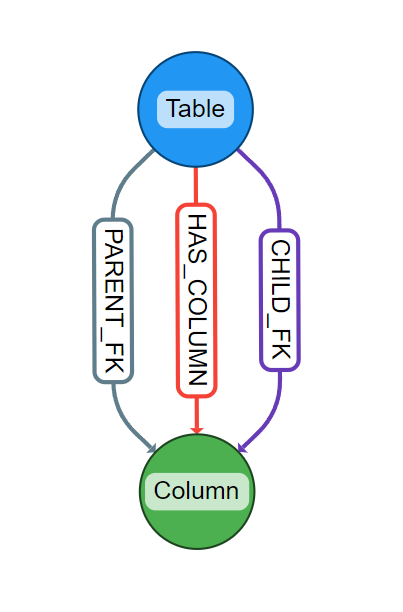

In [14]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/dataKGSchema.png"

# Display the PNG file
Image(filename=png_path)

#### The graph model can now answer questions about how tables are connected

For example:


What's the shortest join path between the **'tags'** and **'items'** tables?


*Table names chosen as the data answers my original question:*
 
**How do I go from where the tags in the database to the actual location for each piece of 
content?**

###### Code: Query Neo4j to see how 2 tables are connected

In [20]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # The shortest join path between the 'tags' and 'items' tables
    query_path = """
    MATCH path = shortestPath((t1:Table {name: 'tags'})-[:PARENT_FK|CHILD_FK*]-(t2:Table {name: 'items'}))
    RETURN path;
    """
    
    result_path = run_cypher_query(query_path)
    
    if len(result_path) == 0:
        print("No paths were returned.")
    else:
        result_path_df = pd.DataFrame(result_path)
        print(f"Full path result:\n{result_path_df}\n")
        # Generate graph from Cypher query
        g = Neo4jGraphWidget(driver)
        g.show_cypher(query_path)

# Close the driver
driver.close()

Neo4j connection established.
Full path result:
                                                path
0  [{'name': 'tags'}, PARENT_FK, {'name': 'tagID'...



GraphWidget(layout=Layout(height='500px', width='100%'))

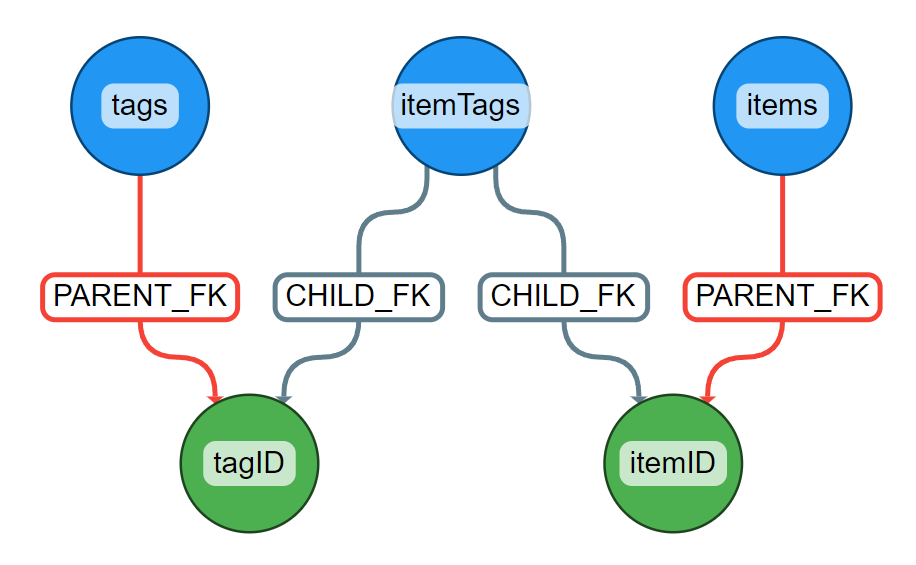

In [21]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/tagsToItemShortestPath.png"

# Display the PNG file
Image(filename=png_path)

##### Results summary: Data KG

- The 'tags' and 'items' tables were specifically chosen given our initial business requirement


- Other join paths are possible by modifying the query - Cypher is designed to make graph traversal queries simple


- Can be extended to investigate other table joins

##### Overlay a chatbot to query the Data KG

Solving Data KG queries involves 3 steps:


1. What are the list of tables in the database?


2. What data does each selected table have?


3. What is the shortest join path for the 2 selected tables?

###### Code: List of tables in the Data KG

In [2]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Connection established.")
       
    query_table_list = """
    MATCH (t:Table)
    RETURN t;
    """
    result_query_table_list = run_cypher_query(query_table_list)
    # print(f'Current contents of:\n{result_query_table_list}\n')
    
    
    # Convert the list of dictionaries to a pandas DataFrame
    df_result_query_table_list = pd.DataFrame(result_query_table_list)
    # Flatten the 'label' column since it's a list
    table_name_list = df_result_query_table_list['t'].apply(lambda x: x["name"]).tolist()
    print(f'List of table names:\n{table_name_list}\n')

# Close the driver
driver.close()

Connection established.
List of table names:
['version', 'baseFieldMappings', 'baseFieldMappingsCombined', 'charsets', 'collectionItems', 'collectionRelations', 'collections', 'creatorTypes', 'creators', 'customBaseFieldMappings', 'customFields', 'customItemTypeFields', 'customItemTypes', 'dbDebug1', 'deletedCollections', 'deletedItems', 'deletedSearches', 'feedItems', 'feeds', 'fieldFormats', 'fields', 'fieldsCombined', 'fileTypeMimeTypes', 'fileTypes', 'fulltextItemWords', 'fulltextItems', 'fulltextWords', 'groupItems', 'groups', 'itemAnnotations', 'itemAttachments', 'itemCreators', 'itemData', 'itemDataValues', 'itemNotes', 'itemRelations', 'itemTags', 'itemTypeCreatorTypes', 'itemTypeFields', 'itemTypeFieldsCombined', 'itemTypes', 'itemTypesCombined', 'items', 'libraries', 'proxies', 'proxyHosts', 'publicationsItems', 'relationPredicates', 'retractedItems', 'savedSearchConditions', 'savedSearches', 'settings', 'storageDeleteLog', 'syncCache', 'syncDeleteLog', 'syncObjectTypes', 'sy

###### Code: Get a sample of 5 record for a selected table

In [5]:
# Create new SQLite connection
with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
    cursor = sqliteConnection.cursor()
    print("Connected to Zotero SQLite")
    
    table_name = 'tags'  # Set the table name dynamically from Gradio selection
    print(f"Table name: {table_name}")
    
    # Dynamically construct the SQL query
    query = f"SELECT * FROM {table_name} LIMIT 5"
    
    cursor.execute(query)
    
    # Fetch column names
    columns = [desc[0] for desc in cursor.description]
    
    rows = cursor.fetchall()
    
    # Convert to Pandas DataFrame (optional)
    df_query_rows = pd.DataFrame(rows, columns=columns)
    print(df_query_rows)

    # Close cursor
    cursor.close()

# Close connection
sqliteConnection.close()
print("SQLite connection closed")

Connected to Zotero SQLite
Table name: tags
   tagID                name
0      1       manufacturing
1      2                 CPD
2      3  government program
3      4            robotics
4      5        productivity
SQLite connection closed


###### Code: Gradio chatbot to view table records

- To determine which tables are of interest

In [6]:
from IPython.display import display, Javascript

# Define a function that takes the selected item from the dropdown
def select_item(selected_table):
    
    # Create new SQLite connection
    with sqlite3.connect('C:\\Users\\georg\\Zotero\\zotero.sqlite') as sqliteConnection:
        cursor = sqliteConnection.cursor()
        # print("Connected to Zotero SQLite")
               
        # Dynamically construct the SQL query
        query = f"SELECT * FROM {selected_table} LIMIT 5"
        
        cursor.execute(query)
        
        # Fetch column names
        columns_gradio = [desc[0] for desc in cursor.description]
        
        rows_gradio = cursor.fetchall()
        
        # Convert to Pandas DataFrame (optional)
        df_query_rows_gradio = pd.DataFrame(rows_gradio, columns=columns_gradio)
        # print(df_query_rows_gradio)

        # Close cursor
        cursor.close()

    # Close connection
    # print("SQLite connection closed")
    
    return df_query_rows_gradio

# Create a Gradio Interface with a dropdown
demo = gr.Interface(
    fn=select_item, #Funtion to call
    inputs=gr.Dropdown(choices=table_name_list, label="Choose table:"),  # Dropdown input
    outputs=[gr.Dataframe(label="First 5 rows:")],                 # Output will be the selected option text
    flagging_mode="never",               # This disables flagging in Gradio 5+
    title="View individual table records",  # Title heading at the top of the interface
    live=False  # Disable live updates, so you have to submit manually
)

demo.launch(inline=True)  # Disable flagging button

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


###### Diagram: Gradio chatbot to view first 5 rows of selected table

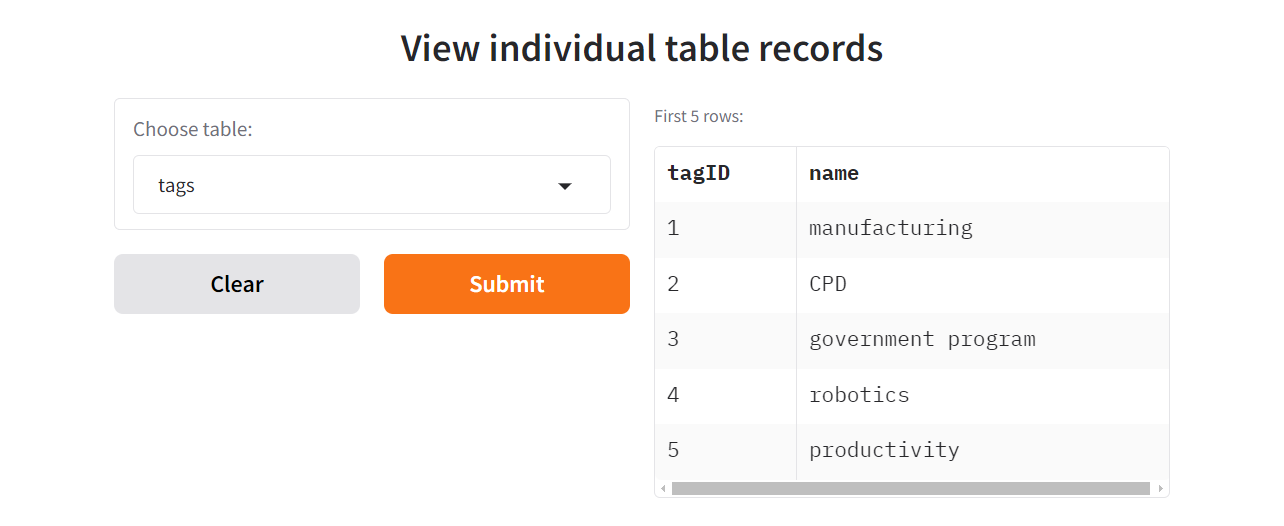

In [7]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"D:\Projects\AICampTalk\Diagrams\PNG\gradioFirst5Rows.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Gradio chatbot to select 2 tables to see their shortest path 

In [11]:
# Global dictionary to store selections
global_state = {"selected_table_1": None, "selected_table_2": None}

# Define a function for chatbot response
def chatbot_response(t1_selection, t2_selection):
    
    #Set selected tables to global state variables 
    global_state["selected_table_1"] = t1_selection
    global_state["selected_table_2"] = t2_selection
    
    return f"Run the next cell to get the join info for `{t1_selection}` and `{t2_selection}`."

# Create Gradio Interface with two independent dropdowns
demo = gr.Interface(
    fn=chatbot_response,  # Function to call
    inputs=[
        gr.Dropdown(choices=table_name_list, label="Table 1:"),  # First table dropdown
        gr.Dropdown(choices=table_name_list, label="Table 2:"),  # Second table dropdown for
    ],  # Inputs
    outputs=gr.Textbox(label="Selected tables:"),  # Text output for the response
    flagging_mode="never",
    title="Select tables for shortest join path",  # Title of the interface
)

# Launch the Gradio interface
demo.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


###### Diagram: Gradio chatbot to select 2 tables for shortest join path

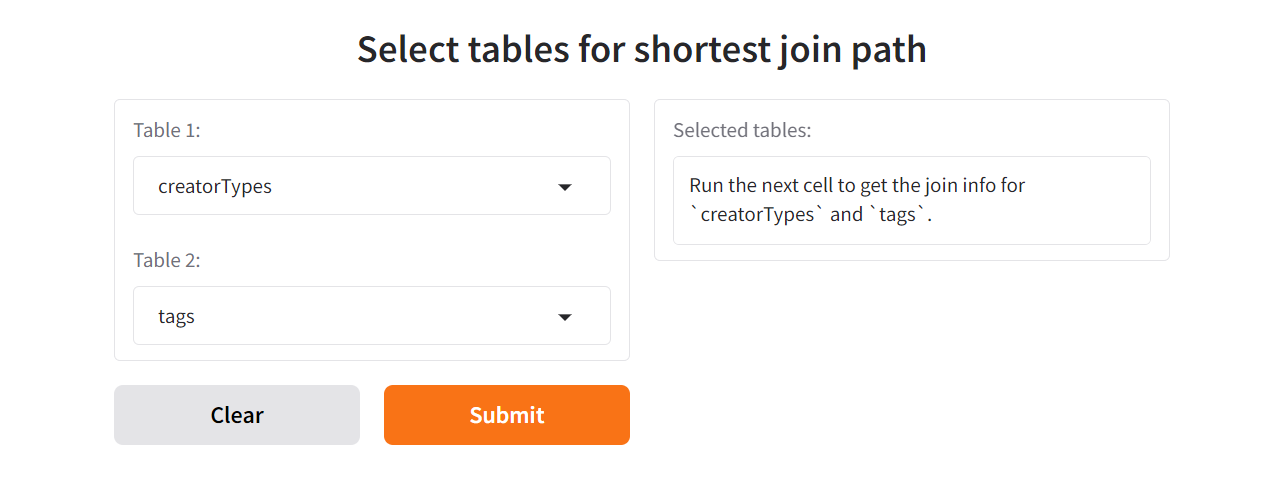

In [14]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"D:\Projects\AICampTalk\Diagrams\PNG\gradioSelect2tables.png"

# Display the PNG file
Image(filename=png_path)

In [13]:
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='sqlite') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")
    
    # Access the stored values
    selected_table_1 = global_state["selected_table_1"]
    selected_table_2 = global_state["selected_table_2"]
    
    print(f"Table 1: {selected_table_1}")
    print(f"Table 2: {selected_table_2}")
    
    # The shortest join path between the 'tags' and 'items' tables
    query_path = f"""
    MATCH path = shortestPath((t1:Table {{name: '{selected_table_1}'}})-[:PARENT_FK|CHILD_FK*]-(t2:Table {{name: '{selected_table_2}'}}))
    RETURN path;
    """
    
    result_path = run_cypher_query(query_path)
    
    if len(result_path) == 0:
        print("No paths were returned.")
    else:
        result_path_df = pd.DataFrame(result_path)
        print(f"Full path result:\n{result_path_df}\n")
        # Generate graph from Cypher query
        g = Neo4jGraphWidget(driver)
        g.show_cypher(query_path)

# Close the driver
driver.close()

Neo4j connection established.
Table 1: creatorTypes
Table 2: tags
Full path result:
                                                path
0  [{'name': 'creatorTypes'}, PARENT_FK, {'name':...



GraphWidget(layout=Layout(height='500px', width='100%'))

###### Diagram: Neo4j query results from Gradio selection

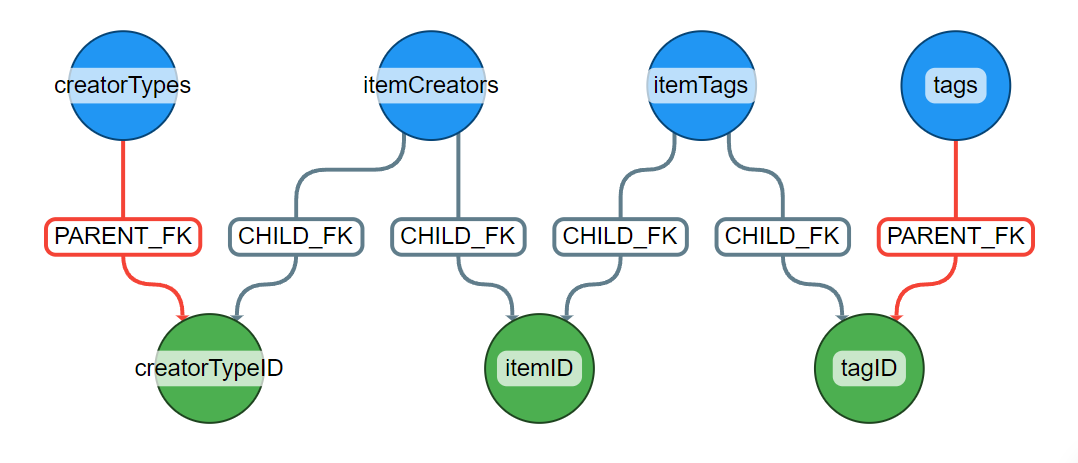

In [158]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/creatorTypesToTagsShortestPath.png"

# Display the PNG file
Image(filename=png_path)

#### Key takeaway from creating a Data KG

1. Doesn't rely on documentation


2. Read and ingest directly from metadata


3. A few lines of code to do the ETL and Cypher query design


4. Immediately see the shortest join path between tables


5. Other join patterns can be specified by modifying the cypher query 


6. Works for all types of databases and datastores



### 4. Part 2: Building a KG for the application layer

#### What do we know about the application code?

Unfortunately from Zotero's own documentation:


> The Zotero JavaScript API is under-documented, and at present requires a lot of looking around in the source code. The most useful parts of the source code are in chrome/content/zotero/xpcom and xpcom/data, and the chrome/content/zotero (particularly zoteroPane.js and fileInterface.js).


But there is metadata for code!


Two major sources of metadata info:


1. Github API - for repo metadata
     
    - Overall repo metrics, filetypes, etc.
 
 
2. The `Abstract Syntax Tree` (AST) - for functions, variables, imports at 
file-level
     
    - Similar approach to static analysis tools like `Semgrep`, `CodeQL` and `Sourcegraph`.

#### Start with a first version of our KG schema - what questions do we want answered

1. What types of files are in the repo?


2. Can I detect a framework?


3. Which language contains the application logic?


4. How can I find out what each file and function does?

###### Diagram: KG schema design for the application layer

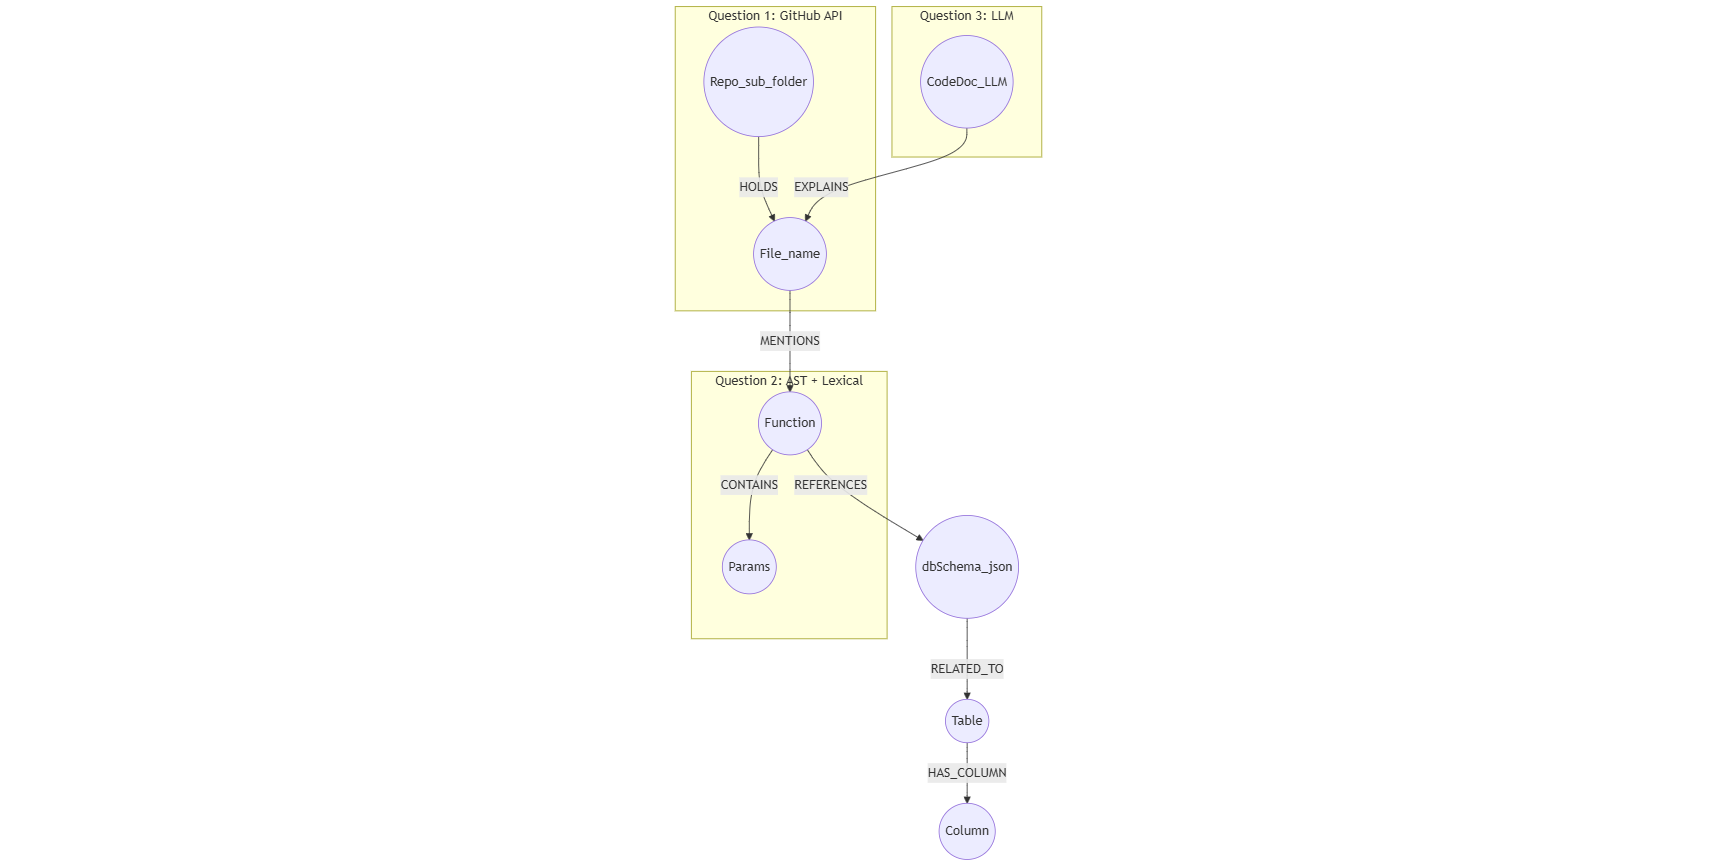

In [15]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appCodeSchemaDesign.png"

# Display the PNG file
Image(filename=png_path)

#### Question 1-3: Repo metadata has the answers

- repo in Github: query via Github APIs
    - repo is too large to be analysed locally
    - KGs should only deal with metadata


- output query results to a CSV file


- upload to neo4j to build the base to analyse relationships

###### Diagram: Schematic of what the code is doing

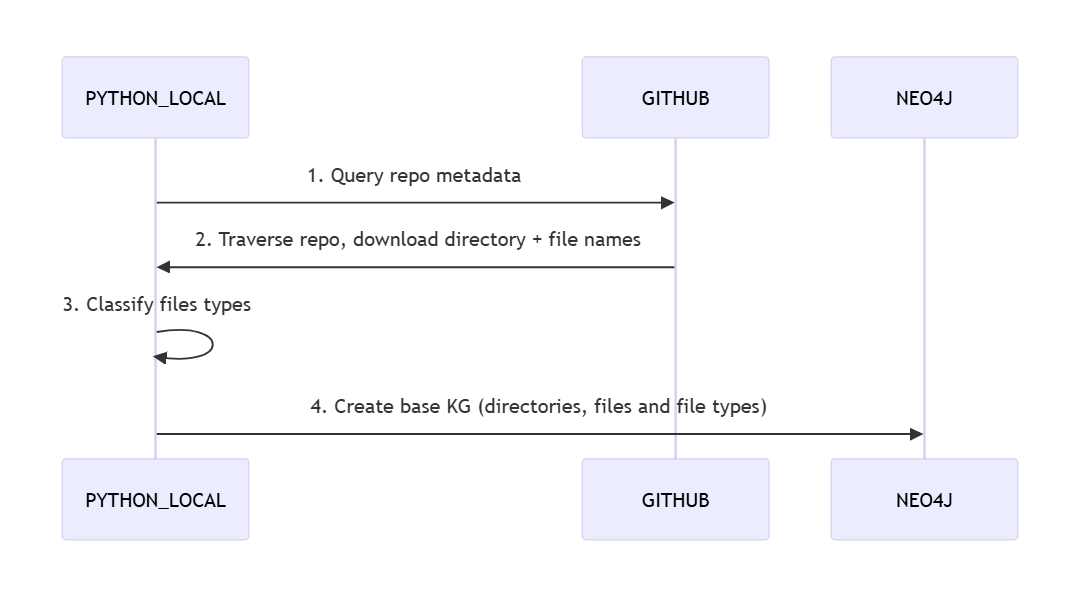

In [16]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appCodeWorkFlow1.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Query Github API to determine what's in the repo:

In [17]:
def get_github_repo_metadata(owner, repo):
    repo_url = f"https://api.github.com/repos/{owner}/{repo}"

    # Fetch repository metadata
    response = requests.get(repo_url)

    if response.status_code == 200:
        data = response.json()
        default_branch = data.get("default_branch", "main")  # Default to 'main' if not found

        # Fetch repository contents (all files and directories)
        contents_url = f"https://api.github.com/repos/{owner}/{repo}/git/trees/{default_branch}?recursive=1"
        contents_response = requests.get(contents_url)

        file_count = 0
        dir_count = 0

        if contents_response.status_code == 200:
            contents_data = contents_response.json()
            for item in contents_data.get("tree", []):
                if item["type"] == "blob":
                    file_count += 1
                elif item["type"] == "tree":
                    dir_count += 1

        metadata = {
            "Name": data.get("name"),
            "Full Name": data.get("full_name"),
            "Description": data.get("description"),
            # "Owner": data["owner"]["login"] if "owner" in data else None,
            "Visibility": data.get("visibility"),
            "Default Branch": default_branch,
            #"Stars": data.get("stargazers_count"),
            # "Forks": data.get("forks_count"),
            # "Watchers": data.get("watchers_count"),
            # "Open Issues": data.get("open_issues_count"),
            # "Created At": data.get("created_at"),
            # "Updated At": data.get("updated_at"),
            # "License": data["license"]["name"] if data.get("license") else "No License",
            "Programming Language": data.get("language"),
            "Size (KB)": data.get("size"),
            "URL": data.get("html_url"),
            "Number of Directories": dir_count,
            "Number of Files": file_count,
        }
        return metadata
    else:
        return f"Error: Unable to fetch data. Status code {response.status_code}"


# Example usage
owner = "zotero"
repo = "zotero"
repo_metadata = get_github_repo_metadata(owner, repo)

# Print the metadata
for key, value in repo_metadata.items():
    print(f"{key}: {value}")

Name: zotero
Full Name: zotero/zotero
Description: Zotero is a free, easy-to-use tool to help you collect, organize, annotate, cite, and share your research sources.
Visibility: public
Default Branch: main
Programming Language: JavaScript
Size (KB): 219055
URL: https://github.com/zotero/zotero
Number of Directories: 361
Number of Files: 3199


###### Code: Classify each accessible file in the repo

In [19]:
# GitHub API Authentication (Set your personal access token here)
HEADERS = {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}

# File extension classification dictionary
file_types = {
    ".py": "Python Script",
    ".md": "Markdown",
    ".txt": "Text",
    ".json": "JSON",
    ".csv": "CSV",
    ".html": "HTML",
    ".js": "Javascript",
    ".css": "CSS",
    ".java": "Java",
    ".cpp": "C++",
    ".c": "C",
    ".h": "Header",
    ".sh": "Shell",
    ".jpg": "JPG",
    ".jpeg": "JPEG",
    ".gif": "GIF",
    ".svg": "SVG",
    ".ico": "ICO",
    ".pyi": "Python_Image",
    ".pyw": "Python_Web",
    ".pyx": "Python_Xml",
    ".bmp": "BMP",
    ".ts": "Typescript",
    ".ipynb": "Jupyter",
    ".ftl": "FreeMarker_Java_template",
    ".dtd": "DTD_XML_def",
    ".properties": "Java_prop",
    ".xhtml": "XHTML",
    ".xml": "XML",
    ".jsx": "Javascript",
    ".yml": "YAML",
    ".gitignore": ".gitignore",
    ".gitmodules": ".gitmodules",
    ".ini": ".ini",
    ".manifest": ".manifest",
    ".jsm": ".jsm",
    ".rdf": "RDF",
    ".zip": "ZIP",
    ".pdf": "PDF",
    ".sqlite": "SQLite",
    ".png": "PNG",
    ".epub": "Epub",
    ".opf": "OPF",
    ".lua": "LUA",
    ".opml": "OPML",
    ".rss": "RSS",
    ".atom": "ATOM",
    ".xpi": "XPI",
    ".csl": "CSL",
    ".scss": "CSS",
    ".woff": "WOFF",
    ".sql": "SQL",
    ".vbs": "VBScript",
    ".idl": "IDL",
    ".mjs": "Javascript",
    ".xul": "XUL",
    ".nsi": "NSI",
    ".nsh": "NSH",
    ".rc": "RC",
    ".nlf": "NLF",
    "": "NONE"
}


# Function to fetch and classify files from a GitHub repository
def classify_files_by_extension(owner, repo, path="", retries=3):
    classified_files = []
    url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"

    for attempt in range(retries):
        response = requests.get(url, headers=HEADERS)

        # Handle rate limiting
        if response.status_code == 403 and "X-RateLimit-Remaining" in response.headers:
            reset_time = int(
                response.headers.get("X-RateLimit-Reset", time.time()))
            wait_time = max(reset_time - time.time(),
                            60)  # Wait until reset or at least 60 sec
            print(f"Rate limited. Sleeping for {wait_time} seconds...")
            time.sleep(wait_time)
            continue

        if response.status_code == 200:
            contents = response.json()
            for item in contents:
                if item["type"] == "file":
                    file_name = item["name"]
                    ext = os.path.splitext(file_name)[1]
                    file_type = file_types.get(ext, "Unknown file type")
                    file_path = item["path"]
                    classified_files.append(
                        {"File Type": file_type,
                         "Directory": os.path.dirname(file_path),
                         "File Name": file_name})
                elif item["type"] == "dir":  # Recursively traverse directories
                    classified_files += classify_files_by_extension(owner, repo,
                                                                    item[
                                                                        "path"],
                                                                    retries=retries)

            return classified_files
        else:
            print(f"Error: {response.status_code} - {response.text}")
            if attempt < retries - 1:
                print(f"Retrying... ({attempt + 1}/{retries})")
                time.sleep(5)  # Wait 5 sec before retrying
            else:
                return []


# Function to save results to Pandas and CSV
def save_to_pandas(classified_files, output_csv="Neo4jImports/repo_files.csv"):
    df_repo_files_all = pd.DataFrame(classified_files)
    df_repo_files_all.to_csv(output_csv, index=False, encoding="utf-8")

    # Compute frequency count of files by type
    file_type_counts = df_repo_files_all["File Type"].value_counts()

    print(f"Results saved to {output_csv}")
    print("\nFile Type Frequency Count:")
    print(file_type_counts)

    return df_repo_files_all, file_type_counts


# Example usage
owner = "zotero"  # Change to the repository owner
repo = "zotero"  # Change to the repository name

classified_files = classify_files_by_extension(owner, repo)
if classified_files:
    df_repo_files_all, file_type_counts = save_to_pandas(classified_files)

Results saved to repo_files.csv

File Type Frequency Count:
File Type
SVG                         713
Javascript                  483
FreeMarker_Java_template    482
DTD_XML_def                 482
Java_prop                   194
CSS                         189
Header                      107
NONE                         78
C++                          77
JSON                         58
XHTML                        52
PNG                          41
.jsm                         25
HTML                         24
Unknown file type            24
PDF                          18
Text                         15
Shell                        12
IDL                          10
GIF                           7
Epub                          7
RSS                           7
NSH                           7
XUL                           6
RC                            6
Typescript                    5
Markdown                      5
NSI                           5
SQL                           4
XM

##### Results Summary: Repo metadata stats

1. Repo Size (KB): 219055


2. Number of Directories: 361


3. Number of Files: 3199


| Filetype                 | No.  | Percentage (%) |
|--------------------------|------|----------------|
| SVG                      | 713  | 22%            |
| Javascript               | 483  | 15%            |
| FreeMarker_Java_template | 482  | 15%            |
| DTD_XML_def              | 482  | 15%            |
| Java_prop                | 194  | 6%             |
| CSS                      | 189  | 6%             |
| Header                   | 107  | 3%             |
| Others                   | 529  | 17%            |
| ------------------------ | ---- | -------------- |
| Total<sup>1<sup>         | 3179 | 100%           |
<sup>1<sup> Numbers don't match repo metadata query result (< 20) - need to check why

##### Import what we know into Neo4j: KGs are built progressively

- directories, file names and file types form the base of the App KG

###### Code: Create repo_files_upload.csv to build a base KG for all Zotero files

In [20]:
# Adjust column names in repo_files.csv

df = pd.read_csv("Neo4jImports/repo_files.csv")

# Rename columns
df = df.rename(columns={"File Name": "file_name", "Directory": "directory",
                        "File Type": "file_type"})
df["directory"] = df["directory"].fillna("ROOT")

# Display the first few rows
print(df.head())

# Save to new csv
df.to_csv("Neo4jImports/repo_files_upload.csv")

  file_type          directory       file_name
0      NONE               ROOT        .babelrc
1      NONE               ROOT  .gitattributes
2      YAML  .github/workflows          ci.yml
3      NONE               ROOT      .gitignore
4      NONE               ROOT     .gitmodules


###### Code: Load repo_files_upload.csv into Neo4j 'apprepo' database

In [23]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH,
                          database='apprepo') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    query_load_repo_files = """
    // Load File Type, Directory, and File Name nodes
    LOAD CSV WITH HEADERS FROM 'file:///repo_files_upload.csv' AS row
    MERGE (f:File {name: row.file_name})
    MERGE (d:Directory {name: row.directory})
    MERGE (t:FileType {type: row.file_type})
    MERGE (d)-[:CONTAINS]->(f)
    MERGE (f)-[:IS_TYPE_OF]->(t);
    """
    result_query_load_repo_files = run_cypher_query(query_load_repo_files)

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

    query_node_frequency = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """
    result_query_node_frequency = run_cypher_query(query_node_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_nodes = pd.DataFrame(result_query_node_frequency)
    # Flatten the 'label' column since it's a list
    df_nodes['label'] = df_nodes['label'].apply(
        lambda x: x[0] if len(x) > 0 else None)
    print("Nodes by Count")
    print(df_nodes)  # Outputs the list of nodes (Persons)

    query_relationship_frequency = """
    MATCH ()-[r]->()
    RETURN type(r) AS relationshipType, COUNT(r) AS count
    ORDER BY count DESC;
    """
    result_query_relationship_frequency = run_cypher_query(
        query_relationship_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_rels = pd.DataFrame(result_query_relationship_frequency)
    # Flatten the 'label' column since it's a list
    # df_rels['label'] = df_rels['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print("Relationships by Count")
    print(df_rels)  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Nodes by Count
       label  count
0       File   1484
1  Directory    261
2   FileType     49
Relationships by Count
  relationshipType  count
0         CONTAINS   3179
1       IS_TYPE_OF   1484


#### Question 4: How are the files, functions and code across the codebase linked?

1. Estimated no. of tokens: 56m (Total bytes / 4)


2. Have to 'chunk' the codebase to fit the context window


3. Fairly clear Javascript files will hold most of the logic


4. Start with Javascript files, parse the rest later.

###### Code: Subset Javascript files

In [2]:
# Check main df 
print(f"Check main df: df_repo_files_all\n")
# Read from previous output
df_repo_files_all = pd.read_csv("Neo4jImports/repo_files.csv")
print(f"{df_repo_files_all.info()}\n")

# Filtering rows where 'File Type' is 'Javascript'
df_repo_files_js = df_repo_files_all[
    df_repo_files_all['File Type'] == 'Javascript']
# print(df_repo_files_js.shape)
print(f"Check javascript df:\n{df_repo_files_js.info()}\n")
print(f"First 5 javascript files:\n{df_repo_files_js.head()}\n")

Check main df: df_repo_files_all

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Type  3179 non-null   object
 1   Directory  3161 non-null   object
 2   File Name  3179 non-null   object
dtypes: object(3)
memory usage: 74.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 483 entries, 15 to 3169
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Type  483 non-null    object
 1   Directory  482 non-null    object
 2   File Name  483 non-null    object
dtypes: object(3)
memory usage: 15.1+ KB
Check javascript df:
None

First 5 javascript files:
      File Type                Directory              File Name
15   Javascript               app/assets  commandLineHandler.js
18   Javascript               app/assets               prefs.js
317  Javascript  chrome/content/scaf

##### 1. Extract javascript functions using the Babel/ES-Lint parser

- Doing things at scale when you don't know:

    - What the function names are

    - Which files define and/or use them
    
    - How they relate across the codebase


- the `Babel/parser` to generate the `Abstract Syntax Tree (AST)` for javascript/JSX/Typescript files


- tells us which names are functions, members of functions (params), objects, etc.


- it is what the `NodeJS` interpreter 'sees' - and is the ultimate source of truth


- at this point we are only interested in function names - `extract_functions.js`

###### Diagram: Schematic of what the code is doing to recursively use Babel locally  

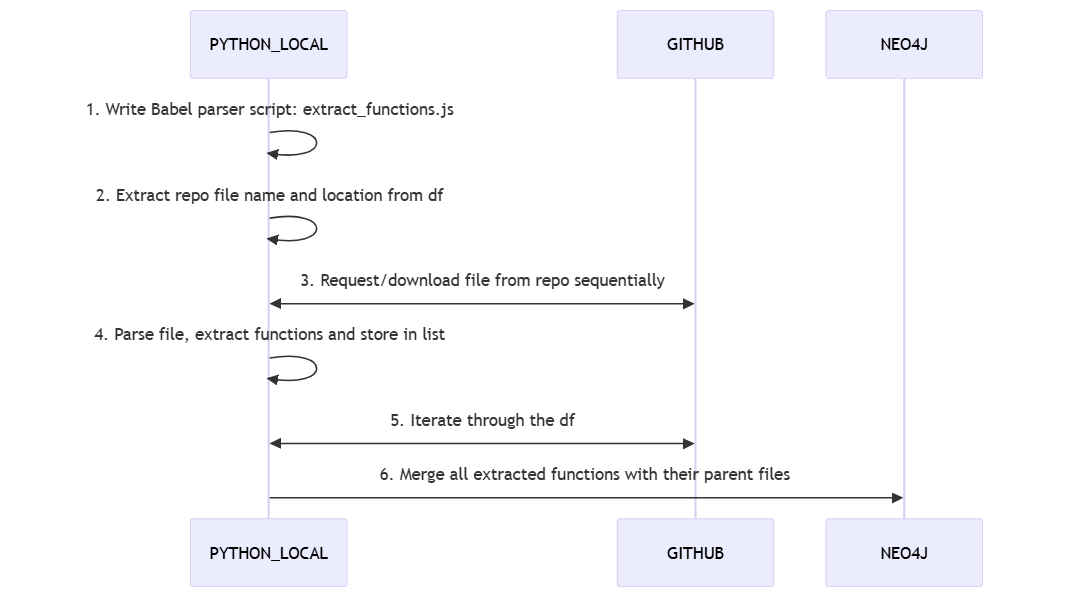

In [25]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appCodeWorkFlow2a.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Extracting functions from javascript files using the Babel parser

In [7]:
# GitHub Repo Info
OWNER = "zotero"
REPO = "zotero"
HEADERS = {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}


# Function to fetch file content from GitHub
def fetch_file_from_github(owner, repo, path):
    url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"
    response = requests.get(url, headers=HEADERS)

    if response.status_code == 200:
        file_data = response.json()
        if "content" in file_data:
            return base64.b64decode(file_data["content"]).decode("utf-8", errors="ignore")
        else:
            print(f"⚠️ No 'content' key in API response for {path}. It might be a directory.")
            return None
    else:
        print(f"❌ Failed to fetch {path}: {response.status_code}, {response.text}")
        return None


# Function to extract functions using Babel Parser
def extract_functions_from_js(js_code):
    temp_file = "temp.js"
    with open(temp_file, "w", encoding="utf-8") as file:
        file.write(js_code)

    result = subprocess.run(
        ['node', 'extract_functions.js', temp_file], capture_output=True, text=True, encoding="utf-8"
    )

    os.remove(temp_file)

    if result.stdout:
        try:
            data = json.loads(result.stdout)
            functions = data.get("functions", [])
            calls = data.get("calls", [])
            imports = data.get("imports", [])

            return functions, calls, imports
        except json.JSONDecodeError:
            print("❌ JSON Decode Error")
            return [], [], []
    return [], [], []


# Process only the first 5 rows
df_repo_files_js_copy = df_repo_files_js.copy()


# Function to process files and extract function data
def process_files_and_extract_functions(df_js_copy, owner, repo):
    function_types, function_names, function_params = [], [], []
    call_names, call_arguments, imports_data = [], [], []

    for _, row in df_js_copy.iterrows():
        file_path = f"{row['Directory']}/{row['File Name']}"
        file_content = fetch_file_from_github(owner, repo, file_path)

        if file_content is None:  # Skip processing if file is missing
            print(f"⚠️ Skipping {file_path} (File not found)")
            function_types.append([])
            function_names.append([])
            function_params.append([])
            call_names.append([])
            call_arguments.append([])
            imports_data.append([])
            continue

        functions, calls, imports = extract_functions_from_js(file_content)

        function_types.append([f.get("type", "UNKNOWN") for f in functions])
        function_names.append([f.get("name", "UNKNOWN") for f in functions])
        function_params.append([f.get("params", []) for f in functions])
        call_names.append([c.get("function", "UNKNOWN") for c in calls])
        call_arguments.append([c.get("arguments", []) for c in calls])
        imports_data.append(imports)

    df_js_copy["Function Types"] = function_types
    df_js_copy["Function Names"] = function_names
    df_js_copy["Function Params"] = function_params
    df_js_copy["Call Names"] = call_names
    df_js_copy["Call Arguments"] = call_arguments
    df_js_copy["Imports"] = imports_data
    return df_js_copy


# Run the processing function
df_repo_files_js_with_functions = process_files_and_extract_functions(
    df_repo_files_js_copy, OWNER, REPO
)

# Convert lists to string format for better readability in CSV
for col in ["Function Types", "Function Names", "Function Params", "Call Names", "Call Arguments", "Imports"]:
    df_repo_files_js_with_functions[col] = df_repo_files_js_with_functions[col].apply(json.dumps)

# Print the first 5 rows
print(df_repo_files_js_with_functions.head())

# Save results to CSV
df_repo_files_js_with_functions.to_csv("Neo4jImports/repo_files_js_with_functions.csv", index=False)


❌ Failed to fetch chrome/content/zotero/integration/addCitationDialog.js: 404, {"message":"Not Found","documentation_url":"https://docs.github.com/rest/repos/contents#get-repository-content","status":"404"}
⚠️ Skipping chrome/content/zotero/integration/addCitationDialog.js (File not found)
❌ Failed to fetch chrome/content/zotero/integration/insertNoteDialog.js: 404, {"message":"Not Found","documentation_url":"https://docs.github.com/rest/repos/contents#get-repository-content","status":"404"}
⚠️ Skipping chrome/content/zotero/integration/insertNoteDialog.js (File not found)
❌ Failed to fetch chrome/content/zotero/integration/quickFormat.js: 404, {"message":"Not Found","documentation_url":"https://docs.github.com/rest/repos/contents#get-repository-content","status":"404"}
⚠️ Skipping chrome/content/zotero/integration/quickFormat.js (File not found)
❌ Failed to fetch nan/eslint.config.mjs: 404, {"message":"Not Found","documentation_url":"https://docs.github.com/rest/repos/contents#get-rep

###### Update neo4j with Javascript files that define, call and import functions

3 separate csv files are needed:


1. functions.csv - stores Functions node by unpacking the Functions list 


2. calls.csv - stores the Calls node by unpacking the Calls list


3. imports.csv - stores Imports node by unpacking the Imports list


- 'csv' files need to be manually transferred to the neo4j import folder

###### Code: 1a) Create functions.csv from repo_files_js_with_functions.csv

In [64]:
# Check the repo_files_js_with_functions.csv readin
df_with_functions_calls_imports = pd.read_csv("Neo4jImports/repo_files_js_with_functions.csv")
# print(df_with_functions_calls_imports.head())

df_with_functions = df_with_functions_calls_imports[['Directory','File Name',
                                                     'Function Types',
                                                     'Function Names', 
                                                     'Function Params']].copy()

# print(df_with_functions.head())

# Check the types of the items inside each column, for example:
"""
for col in df_with_functions.columns:
    print(f"Column '{col}' data types:")
    print(df_with_functions[col].apply(type).value_counts())
    print("-" * 40)
"""

# Convert string representations of lists into actual Python lists
def convert_strings_to_lists(df):
    for col in df.columns:
        try:
            # Try converting the string representation of a list to an actual list
            df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
        except Exception as e:
            print(f"Error converting column {col}: {e}")
    return df

df_with_functions_list = convert_strings_to_lists(df_with_functions)

"""
# Check the types of the items inside each column, for example:
for col in df_with_functions_list.columns:
    print(f"Column '{col}' data types:")
    print(df_with_functions_list[col].apply(type).value_counts())
    print("-" * 40)
"""

# Sample to test code
# df_sample = df_with_functions_list.head()

# Explode the list columns
df_exploded = (df_with_functions_list.explode(['Function Types','Function Names','Function'
                                                                    ' Params'])
               .reset_index
               (drop=True))

df_exploded_with_params = (df_exploded.explode(['Function Params'])
                           .reset_index(drop=True))

print(f"df_exploded:\n{df_exploded_with_params}\n")

# Convert to csv
(df_exploded_with_params.to_csv
 ('Neo4jImports/functions.csv', index=False))


Error converting column Directory: Expecting value: line 1 column 1 (char 0)
Error converting column File Name: Expecting value: line 1 column 1 (char 0)
df_exploded:
                     Directory              File Name  \
0                   app/assets  commandLineHandler.js   
1                   app/assets               prefs.js   
2      chrome/content/scaffold             content.js   
3      chrome/content/scaffold             content.js   
4      chrome/content/scaffold                load.js   
...                        ...                    ...   
12254               test/tests      zoteroPaneTest.js   
12255               test/tests      zoteroPaneTest.js   
12256               test/tests      zoteroPaneTest.js   
12257               test/tests      zoteroPaneTest.js   
12258               test/tests          zoteroTest.js   

                 Function Types  Function Names Function Params  
0                           NaN             NaN             NaN  
1               

###### Code: 1b) Upload functions.csv to neo4j

In [67]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='apprepo') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    query_functions_csv_upload = """
    // Load Function nodes and relationships
    LOAD CSV WITH HEADERS FROM 'file:///functions.csv' AS row
    MERGE (d:Directory {name: row.Directory})
    MERGE (f:File {name: row.`File Name`})
    MERGE (d)-[:CONTAINS]->(f)
    MERGE (func:Function {name: row.`Function Names`})
    MERGE (f)-[:HAS_FUNCTION]->(func)
    MERGE (ft:FunctionType {type: row.`Function Types`})
    MERGE (func)-[:IS_TYPE_OF]->(ft)
    MERGE (fp:FunctionParams {params: row.`Function Params`})
    MERGE (func)-[:HAS_PARAMS]->(fp);
    """
    
    result_query_functions_csv_upload = run_cypher_query(query_functions_csv_upload)
    
    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")
    
    query_node_frequency = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """
    result_query_node_frequency = run_cypher_query(query_node_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_nodes = pd.DataFrame(result_query_node_frequency)
    # Flatten the 'label' column since it's a list
    df_nodes['label'] = df_nodes['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print("Nodes by count")
    print(df_nodes)  # Outputs the list of nodes (Persons)

    query_relationship_frequency = """
    MATCH ()-[r]->()
    RETURN type(r) AS relationshipType, COUNT(r) AS frequency
    ORDER BY frequency DESC;
    """
    result_query_relationship_frequency = run_cypher_query(query_relationship_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_rels = pd.DataFrame(result_query_relationship_frequency)
    # Flatten the 'label' column since it's a list
    # df_rels['label'] = df_rels['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print("Relationships by Count")
    print(df_rels)  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Nodes by count
            label  count
0        Function   4314
1            File   1484
2  FunctionParams   1162
3       Directory    262
4        FileType     49
5    FunctionType      9
Relationships by Count
  relationshipType  frequency
0       HAS_PARAMS       8948
1       IS_TYPE_OF       6400
2     HAS_FUNCTION       5968
3         CONTAINS       3180


###### Code: 2a) Create calls.csv from df_with_functions_calls_imports

In [74]:
df_with_calls = df_with_functions_calls_imports[['Directory','File Name','Call Names']].copy()
# print(df_with_calls.head())

"""
# Check the types of the items inside each column, for example:
for col in df_with_calls.columns:
    print(f"Column '{col}' data types:")
    print(df_with_calls[col].apply(type).value_counts())
    print("-" * 40)
"""
"""
# Convert string representations of lists into actual Python lists
def convert_strings_to_lists(df):
    for col in df.columns:
        try:
            # Try converting the string representation of a list to an actual list
            df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
        except Exception as e:
            print(f"Error converting column {col}: {e}")
    return df
"""
df_with_calls_list = convert_strings_to_lists(df_with_calls)

"""
# Check the types of the items inside each column, for example:
for col in df_with_calls_list.columns:
    print(f"Column '{col}' data types:")
    print(df_with_calls_list[col].apply(type).value_counts())
    print("-" * 40)
"""

# Explode the list columns
df_exploded = (df_with_calls_list.explode(['Call Names']).reset_index
               (drop=True))
print(df_exploded.head())

# Set [Anonymous] to ""
df_exploded['Call Names'] = df_exploded['Call Names'].replace("[Anonymous]", "")

# Convert to csv
(df_exploded.to_csv('Neo4jImports/calls.csv', index=False))


Error converting column Directory: Expecting value: line 1 column 1 (char 0)
Error converting column File Name: Expecting value: line 1 column 1 (char 0)
    Directory              File Name      Call Names
0  app/assets  commandLineHandler.js  importESModule
1  app/assets  commandLineHandler.js      handleFlag
2  app/assets  commandLineHandler.js      handleFlag
3  app/assets  commandLineHandler.js   clearUserPref
4  app/assets  commandLineHandler.js       getBranch


###### Code: 2b) Upload calls.csv to neo4j

In [77]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='apprepo') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    query_calls_csv_upload = """
    // Load Call nodes and relationships
    LOAD CSV WITH HEADERS FROM 'file:///calls.csv' AS row
    WITH row WHERE row.`Call Names` IS NOT NULL AND row.`Call Names` <> ""
    MERGE (d:Directory {name: row.Directory})
    MERGE (f:File {name: row.`File Name`})
    MERGE (d)-[:CONTAINS]->(f)
    MERGE (c:CallFunction {name: row.`Call Names`})
    MERGE (f)-[:HAS_CALL_FUNCTION]->(c)
    WITH c  // Ensure CallFunction exists before checking Function
    MATCH (func:Function {name: c.name})  // Match the Function node if it exists
    MERGE (c)-[:CALLS]->(func);  // Create relationship only if Function exists
    """

    result_query_calls_csv_upload = run_cypher_query(query_calls_csv_upload)

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

    query_node_frequency = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """
    result_query_node_frequency = run_cypher_query(query_node_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_nodes = pd.DataFrame(result_query_node_frequency)
    # Flatten the 'label' column since it's a list
    df_nodes['label'] = df_nodes['label'].apply(
        lambda x: x[0] if len(x) > 0 else None)
    print("Nodes by count")
    print(df_nodes)  # Outputs the list of nodes (Persons)

    query_relationship_frequency = """
    MATCH ()-[r]->()
    RETURN type(r) AS relationshipType, COUNT(r) AS frequency
    ORDER BY frequency DESC;
    """
    result_query_relationship_frequency = run_cypher_query(
        query_relationship_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_rels = pd.DataFrame(result_query_relationship_frequency)
    # Flatten the 'label' column since it's a list
    # df_rels['label'] = df_rels['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print("Relationships by Count")
    print(df_rels)  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Nodes by count
            label  count
0    CallFunction   6371
1        Function   4314
2            File   1484
3  FunctionParams   1162
4       Directory    262
5        FileType     49
6    FunctionType      9
Relationships by Count
    relationshipType  frequency
0  HAS_CALL_FUNCTION      20800
1         HAS_PARAMS       8948
2         IS_TYPE_OF       6400
3       HAS_FUNCTION       5968
4              CALLS       3430
5           CONTAINS       3180


###### Code: 3a) Create imports.csv from df_with_functions_calls_imports

In [78]:
df_with_imports = df_with_functions_calls_imports[['Directory', 'File Name', 'Imports']].copy()
# print(df_with_calls.head())

"""
# Check the types of the items inside each column, for example:
for col in df_with_calls.columns:
    print(f"Column '{col}' data types:")
    print(df_with_calls[col].apply(type).value_counts())
    print("-" * 40)
"""
"""
# Convert string representations of lists into actual Python lists
def convert_strings_to_lists(df):
    for col in df.columns:
        try:
            # Try converting the string representation of a list to an actual list
            df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
        except Exception as e:
            print(f"Error converting column {col}: {e}")
    return df
"""
df_with_imports_list = convert_strings_to_lists(df_with_imports)

"""
# Check the types of the items inside each column, for example:
for col in df_with_calls_list.columns:
    print(f"Column '{col}' data types:")
    print(df_with_calls_list[col].apply(type).value_counts())
    print("-" * 40)
"""

# Explode the list columns
df_exploded = (df_with_imports_list.explode(['Imports']).reset_index
               (drop=True))
print(df_exploded.head())

# Set [Anonymous] to ""
# df_exploded['Call Names'] = df_exploded['Call Names'].replace("[Anonymous]",
# "")

# Convert to csv
(df_exploded.to_csv('Neo4JImports/imports.csv', index=False))


Error converting column Directory: Expecting value: line 1 column 1 (char 0)
Error converting column File Name: Expecting value: line 1 column 1 (char 0)
                 Directory              File Name Imports
0               app/assets  commandLineHandler.js     NaN
1               app/assets               prefs.js     NaN
2  chrome/content/scaffold             content.js     NaN
3  chrome/content/scaffold                load.js     NaN
4  chrome/content/scaffold            scaffold.js     NaN


###### Code: 3b) Upload imports.csv to neo4j

In [79]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH,
                          database='apprepo') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    query_imports_csv_upload = """
    // Load Call nodes and relationships
    LOAD CSV WITH HEADERS FROM 'file:///imports.csv' AS row
    WITH row WHERE row.Imports IS NOT NULL AND row.Imports <> ""
    MERGE (d:Directory {name: row.Directory})
    MERGE (f:File {name: row.`File Name`})
    MERGE (d)-[:CONTAINS]->(f)
    MERGE (i:ImportFunction {name: row.Imports})
    MERGE (f)-[:HAS_IMPORT_FUNCTION]->(i)
    WITH i  // Ensure ImportFunction exists before checking Function
    MATCH (func:Function {name: i.name})  // Match the Function node if it exists
    MERGE (i)-[:IMPORTS]->(func);  // Create relationship only if Function exists
    """

    result_query_imports_csv_upload = run_cypher_query(query_imports_csv_upload)

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

    query_node_frequency = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """
    result_query_node_frequency = run_cypher_query(query_node_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_nodes = pd.DataFrame(result_query_node_frequency)
    # Flatten the 'label' column since it's a list
    df_nodes['label'] = df_nodes['label'].apply(
        lambda x: x[0] if len(x) > 0 else None)
    print("Nodes by count")
    print(df_nodes)  # Outputs the list of nodes (Persons)

    query_relationship_frequency = """
    MATCH ()-[r]->()
    RETURN type(r) AS relationshipType, COUNT(r) AS frequency
    ORDER BY frequency DESC;
    """
    result_query_relationship_frequency = run_cypher_query(
        query_relationship_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_rels = pd.DataFrame(result_query_relationship_frequency)
    # Flatten the 'label' column since it's a list
    # df_rels['label'] = df_rels['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print("Relationships by Count")
    print(df_rels)  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Nodes by count
            label  count
0    CallFunction   6371
1        Function   4314
2            File   1484
3  FunctionParams   1162
4       Directory    262
5        FileType     49
6  ImportFunction     18
7    FunctionType      9
Relationships by Count
      relationshipType  frequency
0    HAS_CALL_FUNCTION      20800
1           HAS_PARAMS       8948
2           IS_TYPE_OF       6400
3         HAS_FUNCTION       5968
4                CALLS       3430
5             CONTAINS       3180
6  HAS_IMPORT_FUNCTION         34
7              IMPORTS          7


###### Diagram: AppKG schema after parsing all JS files with functions (AST)

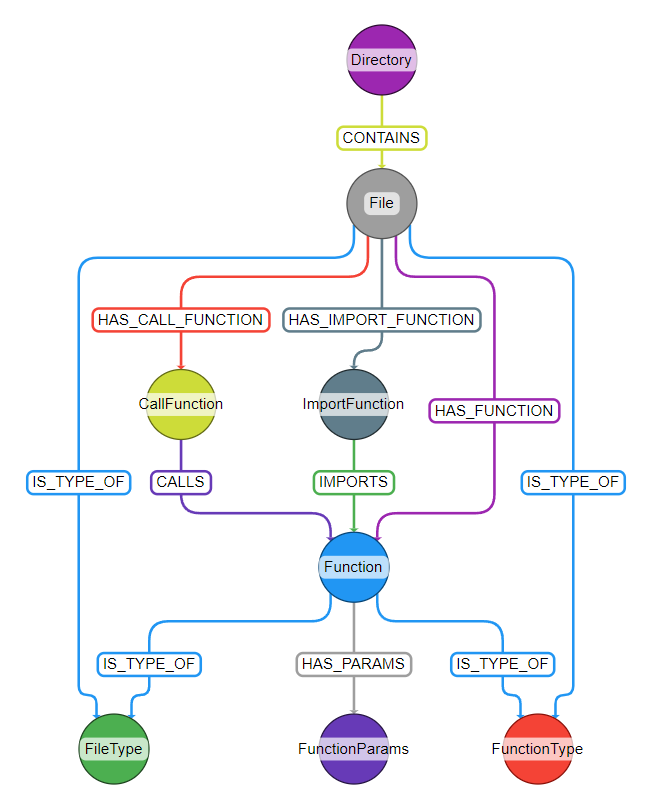

In [85]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appKGAst.png"

# Display the PNG file
Image(filename=png_path)

##### 2. Identify relationships in non-Javascript files using Github's
CodeSearch API

- Parsing files for their ASTs are language-specific


- Parsing the AST already gives us the names of files, functions, params, 
etc.


- lexical/free-text search can identify relationships with other file-types


- Github CodeSearch API completely revamped in 2023


- Moved from ElasticSearch to an in-house developed solution

###### Diagram: Code flow for lexical search via Github CodeSearch API

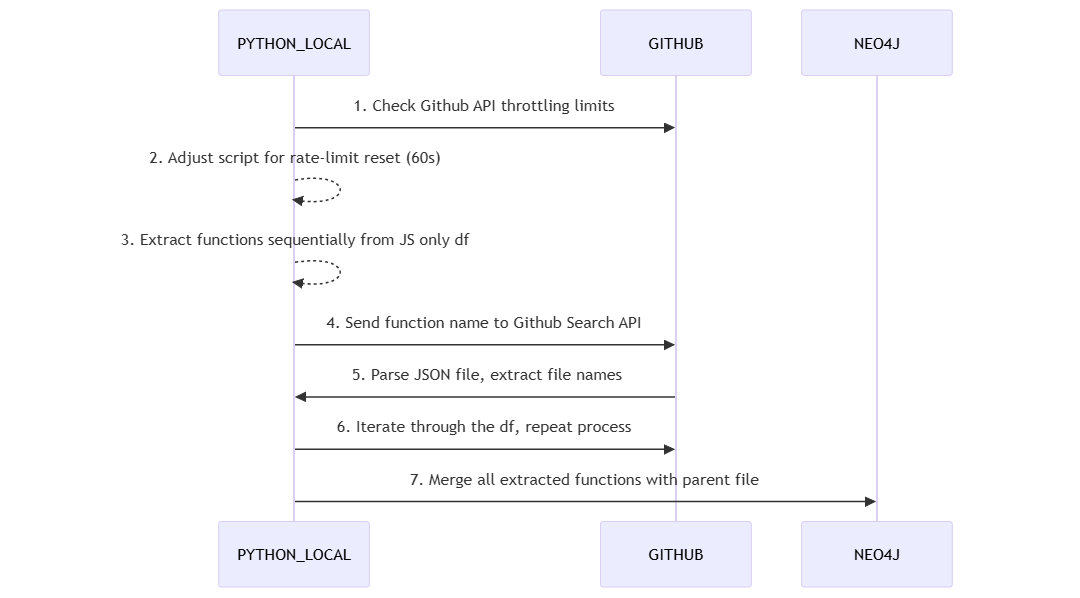

In [27]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appCodeWorkFlow2b.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Check Github API rate limits for authenticated users

**Github API is limited to 30 per minute!**


- For authenticated users - with a `personal access token`


- Must add throttling to work within the rate-limits

###### Code: Check current API rate-limits with a Github personal access toke 

In [2]:
# Replace 'your_token_here' with your actual GitHub token
HEADERS = {
    'Authorization': f'token {GITHUB_TOKEN}',
    'Accept': 'application/vnd.github.v3+json'
}

response = requests.get('https://api.github.com/rate_limit', headers=HEADERS)
data = response.json()

# To see the rate limit for search code specifically
print(data['resources']['search']['remaining'])

# Get the reset time for the search API
reset_timestamp = data['resources']['search']['reset']

# Convert the reset timestamp to a human-readable format
reset_time_utc = datetime.datetime.fromtimestamp(reset_timestamp,
                                                 datetime.timezone.utc)

# Convert the UTC time to AEDT (Australian Eastern Daylight Time)
aedt_tz = pytz.timezone('Australia/Sydney')
reset_time_aedt = reset_time_utc.astimezone(aedt_tz)

print(f"Your GitHub Search API rate limit will reset at: {reset_time_aedt}")


30
Your GitHub Search API rate limit will reset at: 2025-04-02 14:29:07+11:00


###### Code: [Not executed] Github CodeSearch API lexical search of all file names regardless of where they occur

- **Caution:** even with multithreading calls, execution time can run for hours

In [4]:
from concurrent.futures import ThreadPoolExecutor

# Search Zotero repo only
repo_owner = "zotero"  # Replace with the repository owner
repo_name = "zotero"  # Replace with the repository name

# Load CSV file
df_repo_files_js = pd.read_csv("Neo4jImports/repo_files_js_with_functions.csv")

# Subset the DataFrame to the first 20 records
df_sample = df_repo_files_js.head(20)

def search_github_file(file_name):
    """Search for a file name in GitHub repo."""
    search_url = "https://api.github.com/search/code"
    query = f"{file_name} repo:{repo_owner}/{repo_name}"
    
    headers = {"Accept": "application/vnd.github.v3+json"}
    if GITHUB_TOKEN:
        headers["Authorization"] = f"token {GITHUB_TOKEN}"
    
    response = requests.get(search_url, headers=headers, params={"q": query})
    
    if response.status_code == 200:
        return response.json().get("items", [])
    elif response.status_code == 403 and "X-RateLimit-Remaining" in response.headers:
        reset_time = int(response.headers.get("X-RateLimit-Reset", time.time()))
        wait_time = max(reset_time - time.time(), 60)
        print(f"Rate limited. Sleeping for {wait_time} seconds...")
        time.sleep(wait_time)
        return search_github_file(file_name)  # Retry
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return []

# Use ThreadPoolExecutor for parallel execution
results_list = []
def process_file(file_name, original_directory):
    matches = search_github_file(file_name.strip())
    for match in matches:
        directory = re.sub(r".*/blob/[^/]+(/.*?)/[^/]+$", r"\1", match["path"])
        results_list.append({
            "Original Directory": original_directory,  # Retain the original directory for duplicates
            "Directory": directory,
            "File Name": match["name"],
            "Matched File Name": file_name
        })

with ThreadPoolExecutor(max_workers=5) as executor:  # Run 5 searches in parallel
    executor.map(process_file, df_sample["File Name"], df_sample["Directory"])

# Convert results into DataFrame
df_repo_files_linked = pd.DataFrame(results_list)

# Save results
df_repo_files_linked.to_csv("repo_files_linked.csv", index=False)
print(df_repo_files_linked.head())

Rate limited. Sleeping for 60 seconds...
Rate limited. Sleeping for 60 seconds...
Rate limited. Sleeping for 60 seconds...
Rate limited. Sleeping for 60 seconds...
Rate limited. Sleeping for 60 seconds...
Rate limited. Sleeping for 60 seconds...
Rate limited. Sleeping for 60 seconds...
        Original Directory                                          Directory  \
0  chrome/content/scaffold                 chrome/content/scaffold/load.xhtml   
1  chrome/content/scaffold                chrome/content/scaffold/scaffold.js   
2  chrome/content/scaffold    chrome/content/zotero/standalone/basicViewer.js   
3  chrome/content/scaffold  chrome/content/zotero/actors/TranslationChild.jsm   
4               app/assets                   app/assets/commandLineHandler.js   

               File Name      Matched File Name  
0             load.xhtml                load.js  
1            scaffold.js             content.js  
2         basicViewer.js             content.js  
3   TranslationChild.jsm  

###### Code: Lexical search using Github API for 10 files of choice

- For demo purposes a truncated file of 10 files will be used

In [90]:
# Load CSV file
df_repo_files_js = pd.read_csv("Neo4jImports/repo_files_js_with_functions.csv")

# Subset the files with 10 'randomly' chosen Javascript files
chosen_files = [("chrome/content/zotero", "include.js"),
                ("chrome/content/zotero", "customElements.js"),
                ("chrome/content/zotero/xpcom", "zotero.js"),
                ("chrome/content/scaffold", "content.js"),
                ("chrome/content/zotero", "titlebar.js"),
                ("chrome/content/zotero", "createParentDialog.js"), 
                ("chrome/content/zotero/integration", "addCitationDialog.js"),
                ("chrome/content/zotero", "advancedSearch.js"),
                ("chrome/content/zotero", "contextPane.js"),
                ("chrome/content/zotero/integration", "editBibliographyDialog.js")]

df_repo_files_js_10 = df_repo_files_js[df_repo_files_js[["Directory", "File "
                                                                      "Name"]].apply(tuple, axis=1).isin(chosen_files)]

df_repo_files_js_10_sub = df_repo_files_js_10[["Directory", "File Name"]] 

print(df_repo_files_js_10_sub.head())

                  Directory              File Name
2   chrome/content/scaffold             content.js
18    chrome/content/zotero      advancedSearch.js
47    chrome/content/zotero         contextPane.js
48    chrome/content/zotero  createParentDialog.js
49    chrome/content/zotero      customElements.js


In [95]:
from concurrent.futures import ThreadPoolExecutor

# Search Zotero repo only
repo_owner = "zotero"  # Replace with the repository owner
repo_name = "zotero"  # Replace with the repository name

def search_github_file(file_name):
    """Search for a file name in GitHub repo."""
    search_url = "https://api.github.com/search/code"
    query = f"{file_name} repo:{repo_owner}/{repo_name}"

    headers = {"Accept": "application/vnd.github.v3+json"}
    if GITHUB_TOKEN:
        headers["Authorization"] = f"token {GITHUB_TOKEN}"

    response = requests.get(search_url, headers=headers, params={"q": query})

    if response.status_code == 200:
        return response.json().get("items", [])
    elif response.status_code == 403 and "X-RateLimit-Remaining" in response.headers:
        reset_time = int(response.headers.get("X-RateLimit-Reset", time.time()))
        wait_time = max(reset_time - time.time(), 60)
        print(f"Rate limited. Sleeping for {wait_time} seconds...")
        time.sleep(wait_time)
        return search_github_file(file_name)  # Retry
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return []


# Use ThreadPoolExecutor for parallel execution
results_list = []


def process_file(original_directory, file_name):
    matches = search_github_file(file_name.strip())
    for match in matches:
        directory = re.sub(r".*/blob/[^/]+/(.*?)/[^/]+$", r"\1", match["path"])
        results_list.append({
            # Retain the original directory for duplicates
            "Directory": original_directory,
            "File Name": file_name,
            "Matched Directory": directory,
            "Matched File Name": match["name"]
        })


with ThreadPoolExecutor(
        max_workers=5) as executor:  # Run 5 searches in parallel
    executor.map(process_file, df_repo_files_js_10_sub["Directory"], df_repo_files_js_10_sub["File Name"])

# Convert results into DataFrame
df_repo_files_linked_10 = pd.DataFrame(results_list)
print(df_repo_files_linked_10.head())

Rate limited. Sleeping for 60 seconds...
               Directory          File Name  \
0  chrome/content/zotero     contextPane.js   
1  chrome/content/zotero     contextPane.js   
2  chrome/content/zotero  customElements.js   
3  chrome/content/zotero  customElements.js   
4  chrome/content/zotero  customElements.js   

                         Matched Directory  Matched File Name  
0  chrome/content/zotero/customElements.js  customElements.js  
1   chrome/content/zotero/zoteroPane.xhtml   zoteroPane.xhtml  
2  chrome/content/zotero/customElements.js  customElements.js  
3         scss/xulElementPatches/README.md          README.md  
4       scss/xulElementPatches/wizard.scss        wizard.scss  


###### Code: Cleanup 'Matched Directory' with regex and save to csv

In [97]:
# Directly modify the existing 'path' column
df_repo_files_linked_10['Matched Directory'] = df_repo_files_linked_10['Matched Directory'].str.replace(r'/[^/]+$', '', regex=True)
print(df_repo_files_linked_10.tail())

# Save as csv
df_repo_files_linked_10.to_csv("Neo4jImports/repo_files_linked_10.csv", index=False)

###### Code: Upload non-Javascript linked files to neo4j

In [103]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH,
                          database='apprepo') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    query_linked_10_csv_upload = """
    // Load linked relationships
    LOAD CSV WITH HEADERS FROM 'file:///repo_files_linked_10.csv' AS row
    MATCH (d1:Directory)-[:CONTAINS]->(f1:File)
    WHERE d1.name = row.Directory AND f1.name = row.`File Name`
    MATCH (d2:Directory)-[:CONTAINS]->(f2:File)
    WHERE d2.name = row.`Matched Directory` AND f2.name = row.`Matched File Name`
    WITH f1, f2
    WHERE f1 IS NOT NULL AND f2 IS NOT NULL  // Ensure both exist
    MERGE (f1)-[:ALSO_FOUND_IN]->(f2);
    """

    result_query_linked_10_csv_upload = run_cypher_query(query_linked_10_csv_upload)

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

    query_node_frequency = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """
    result_query_node_frequency = run_cypher_query(query_node_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_nodes = pd.DataFrame(result_query_node_frequency)
    # Flatten the 'label' column since it's a list
    df_nodes['label'] = df_nodes['label'].apply(
        lambda x: x[0] if len(x) > 0 else None)
    print("Nodes by count")
    print(df_nodes)  # Outputs the list of nodes (Persons)

    query_relationship_frequency = """
    MATCH ()-[r]->()
    RETURN type(r) AS relationshipType, COUNT(r) AS frequency
    ORDER BY frequency DESC;
    """
    result_query_relationship_frequency = run_cypher_query(
        query_relationship_frequency)
    # Convert the list of dictionaries to a pandas DataFrame
    df_rels = pd.DataFrame(result_query_relationship_frequency)
    # Flatten the 'label' column since it's a list
    # df_rels['label'] = df_rels['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print("Relationships by Count")
    print(df_rels)  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Nodes by count
            label  count
0    CallFunction   6371
1        Function   4314
2            File   1484
3  FunctionParams   1162
4       Directory    262
5        FileType     49
6  ImportFunction     18
7    FunctionType      9
Relationships by Count
      relationshipType  frequency
0    HAS_CALL_FUNCTION      20800
1           HAS_PARAMS       8948
2           IS_TYPE_OF       6400
3         HAS_FUNCTION       5968
4                CALLS       3430
5             CONTAINS       3180
6        ALSO_FOUND_IN         98
7  HAS_IMPORT_FUNCTION         34
8              IMPORTS          7


###### Diagram: AppKG Schema (AST + Lexical search)

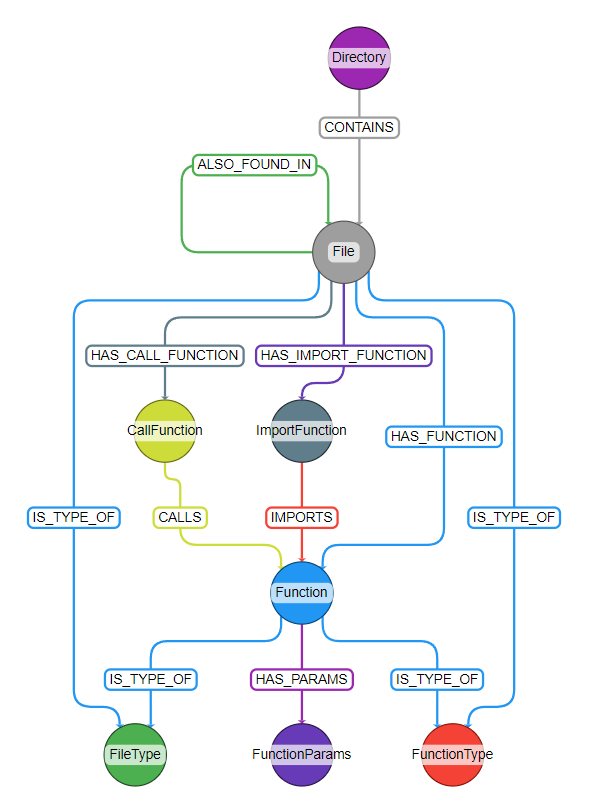

In [10]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appKGSchemaAll.png"

# Display the PNG file
Image(filename=png_path)

##### Results Summary: Populating the App KG

Creating App KG involves 3 steps:


1. Ingesting the Github repo directory structure and file types to form a base


2. Using the Babel parser to extract function names, calls and imports from the AST


3. Using the Github CodeSearch API to find where else the Javascript files are used


The App KG can now show how the Javascript files are linked and used

##### Overlay a Gradio chatbot to query the App KG

###### Code: Get list of files 

In [ ]:
with (GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='apprepo') as driver):
    driver.verify_connectivity()
    print("Connection established.")

    query_js_functions_file_list = """
    MATCH (f:File)-[:HAS_FUNCTION]-(func:Function)
    RETURN DISTINCT f;
    """
    result_query_js_functions_file_list = run_cypher_query(query_js_functions_file_list)
    # print(f'Current contents of:\n{result_query_table_list}\n')

    # Convert the list of dictionaries to a pandas DataFrame
    df_result_query_js_functions_file_list = pd.DataFrame(result_query_js_functions_file_list)
    # Flatten the 'label' column since it's a list
    js_function_file_name_list = df_result_query_js_functions_file_list['f'
    ].apply(lambda x: x["name"]).tolist()
    print(f'List of JS files with functions:\n{js_function_file_name_list}\n')

# Close the driver
driver.close()

###### Code: Gradio chatbot to select files for graph view  

In [4]:
# Global state to store selected values
selected_files = []
selected_relationships = []

# Function to handle selection
def handle_file_selection(file_selections):
    global selected_files
    if len(file_selections) > 5:
        return selected_files, "You can select up to 5 options only."
    else:
        selected_files = file_selections
        return selected_files, (f"✅ You selected {len(file_selections)} option"
                                f"(s).")

# Function to handle relationship selection (no limit)
def handle_relationship_selection(relationship_selections):
    global selected_relationships
    selected_relationships = relationship_selections
    return selected_relationships, (f"✅ {len(relationship_selections)} "
                                    f"relationship(s)elected.")


# Relationship options
relationship_options = ["HAS_FUNCTION", "HAS_CALL_FUNCTION", "HAS_IMPORT_FUNCTION", "ALSO_FOUND_IN"]

# Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("### Select Javascript files (max 5 files)")
    
    file_dropdown = gr.Dropdown(
        choices=js_function_file_name_list,
        multiselect=True,
        label="Javascript Files:"
    )
    
    file_output = gr.Textbox(label="Selected files:")
    file_message = gr.Textbox(label="Message", interactive=False)
    
    file_dropdown.change(fn=handle_file_selection, inputs=file_dropdown, 
                     outputs=[file_output, file_message])

    gr.Markdown("### Select Relationship types (multiple selections allowed)")

    relationship_dropdown = gr.Dropdown(
        choices=relationship_options,
        multiselect=True,
        label="Relationship Types"
    )

    relationship_output = gr.Textbox(label="Selected relationships:")
    relationship_message = gr.Textbox(label="Message", interactive=False)

    relationship_dropdown.change(fn=handle_relationship_selection, inputs=relationship_dropdown, outputs=[relationship_output, relationship_message])

demo.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


###### Diagram: Gradio chatbot for AppKG selection

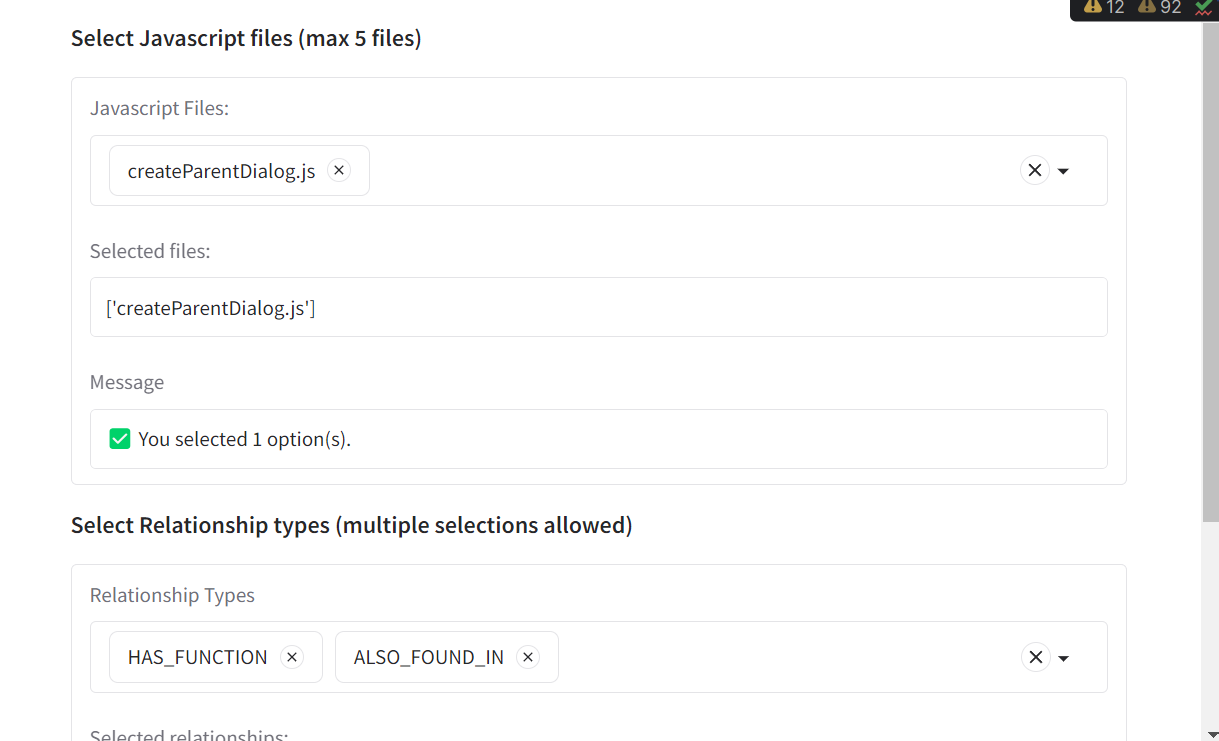

In [11]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appKGGradio.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Generate Neo4j graph from Gradio selection

In [8]:
with (GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='apprepo') as driver):
    driver.verify_connectivity()
    print("Neo4j connection established.")
    
    # Convert relationship list to Cypher format
    rel_types = '|'.join(selected_relationships)
    
    # Access the stored values
    query_js_selected_node = f"""
    MATCH (f:File)-[r:{rel_types}]-(n)
    WHERE f.name IN {selected_files}
    RETURN f, r, n
    """
    
    result_query_js_selected_node = run_cypher_query(query_js_selected_node)
    
    # Print results
    # for row in result_query_js_selected_node:
    #     print(row)
    
    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    g.show_cypher(query_js_selected_node)
    
# Close the driver
driver.close()

Neo4j connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

###### Diagram: Neo4j query result from Gradio selection

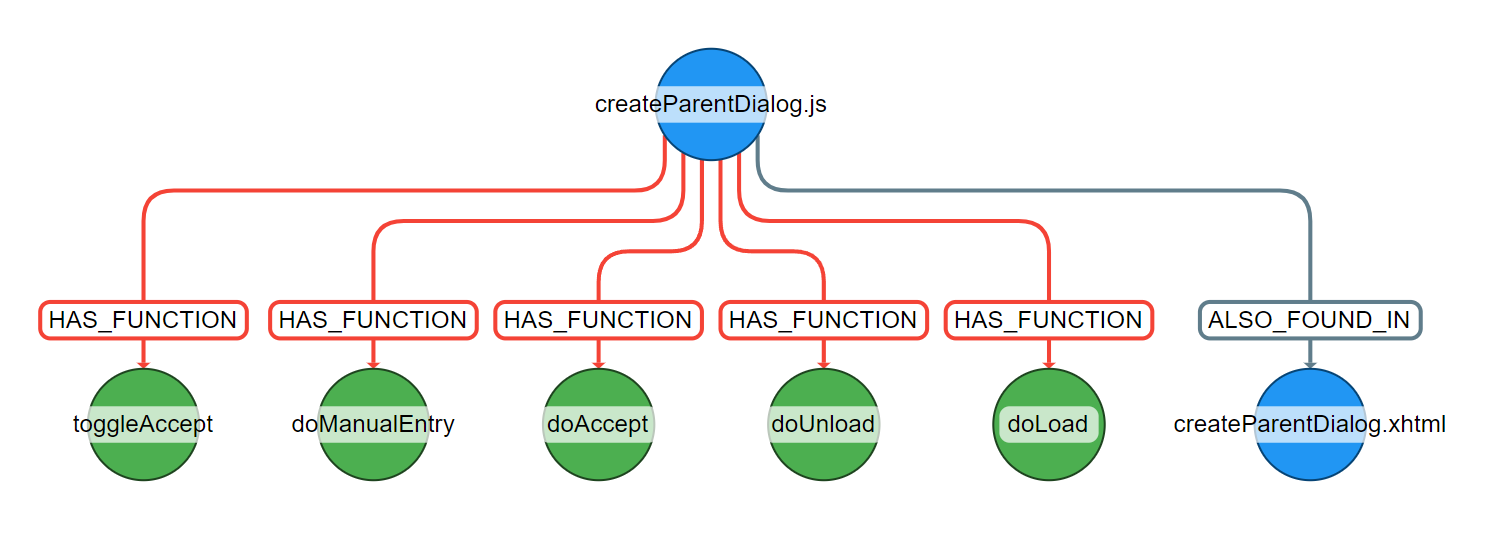

In [12]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appKGGradioQueryResult.png"

# Display the PNG file
Image(filename=png_path)

###### Result summary:

- Adding a chatbot interface simplifies the selection of files and relationships for Neo4j queries


- The file selection tool also serves as a method to manage LLM prompting aka GraphRAG



#### Getting an LLM to explain code in natural language - GraphRAG

- although we have a robust way to see how the codebase is connected, getting a natural language explanation of what pieces of the code helps with the next stage of App KG enhancements


- all LLMs have an input token context limit - 128K tokens


- but by querying the App KG, we have a controlled method for sending sections of code for explanations






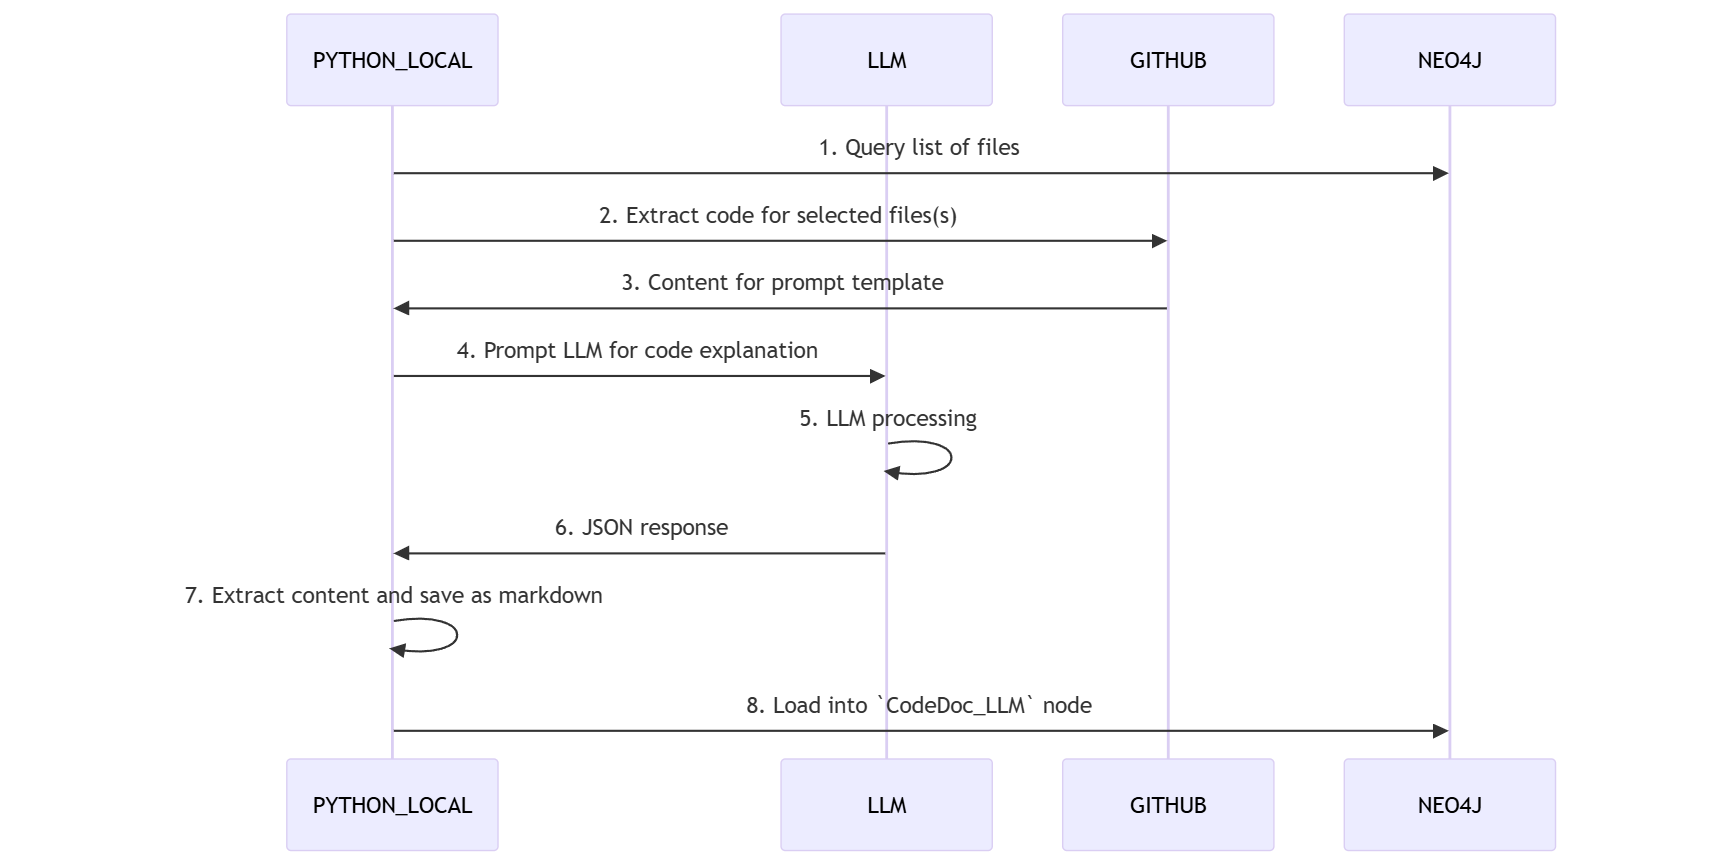

In [20]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appCodeWorkFlow3.png"

# Display the PNG file
Image(filename=png_path)

###### Code: 1. Gradio chatbot to choose files without docs

- Must run all code in sequence


In [13]:
# --- Global Variables ---
missing_files = []
fetched_directories = []
selected_file = None

# Neo4j graph connection
driver = GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='apprepo')

# --- Neo4j Connectivity ---
driver.verify_connectivity()
print("Connection to Neo4j established.")

# --- Function to Get Files Missing LLM Doc ---
def get_files_missing_llm_doc():
    global missing_files
    with driver.session() as session:
        result = session.run("""
            MATCH (f:File)
            WHERE NOT (f)-[:HAS_LLM_DOC]-(:CodeDoc_LLM)
              AND (f)-[:HAS_FUNCTION]-(:Function)
            RETURN f.name AS fileName ORDER BY toLower(fileName)
        """)
        missing_files = [record["fileName"] for record in result]
    return missing_files

# --- Function to Get Directories for a File ---
def get_directories_for_file(file_name):
    global fetched_directories
    print(f"Looking up directories for file: {file_name}")

    with driver.session() as session:
        result = session.run("""
            MATCH (d:Directory)-[:CONTAINS]-(f:File {name: $file_name})
            RETURN d.name AS dirName ORDER BY dirName
        """, {"file_name": file_name})

        fetched_directories = [record["dirName"] for record in result]
        print(f"Directories found: {fetched_directories}")

    return fetched_directories if fetched_directories else ["No directories found."]

# --- Handler for Gradio Submit ---
def on_fetch_directories(file_name):
    global selected_file
    selected_file = file_name
    directories = get_directories_for_file(file_name)
    count = len(directories) if directories and "No directories found." not in directories[0] else 0
    message = f"✅ Found {count} director{'y' if count == 1 else 'ies'} for `{file_name}`" if count > 0 else "No directories found."
    return "\n".join(directories), message

# --- Initialize Missing Files Once ---
missing_files = get_files_missing_llm_doc()

# --- Gradio UI ---
with gr.Blocks() as demo:
    gr.Markdown("#### Files without LLM Docs: Directory Retriever")

    file_dropdown = gr.Dropdown(choices=missing_files, label="Select a File without LLM Doc")
    directory_list = gr.Textbox(label="Directories associated with file:")
    fetch_button = gr.Button("Fetch Directories")
    output = gr.Markdown()

    fetch_button.click(fn=on_fetch_directories, inputs=file_dropdown, outputs=[directory_list, output])

demo.launch()

# --- Cleanup ---
driver.close()


Connection to Neo4j established.
* Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


###### Code: Gradio chatbot to choose directory + file combo for Github retrieval

###### 2. Gradio chatbot to retrieve file contents from Github

In [19]:
HEADERS = {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}

repo_owner = "zotero"
repo_name = "zotero"

file_directory = []
file_contents = []

def fetch_file_contents_from_github(owner, repo, path):
    url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"
    response = requests.get(url, headers=HEADERS)

    if response.status_code == 200:
        file_data = response.json()
        if "content" in file_data:
            decoded = base64.b64decode(file_data["content"]).decode("utf-8", errors="ignore")
            return decoded
        else:
            return f"No 'content' in response. Path may be a directory: {path}"
    else:
        return f"❌ Failed to fetch {path}: {response.status_code}, {response.text}"


# --- Gradio Fetch Handler ---
def on_fetch_from_github(selected_directory, file_name):
    global file_directory
    global file_contents
    if not selected_directory or not file_name:
        return "Please select both a directory and a file."

    file_directory = selected_directory

    full_path = f"{selected_directory}/{file_name}"

    file_contents = fetch_file_contents_from_github(repo_owner, repo_name, full_path)

    return file_contents

# --- Gradio UI ---
with gr.Blocks() as demo:
    gr.Markdown("#### Selected Directory + File: Github Code Retriever")

    directory_list_dropdown = gr.Dropdown(choices=fetched_directories, label="Select Directory (if multiple shown):")
    preselected_file = gr.Textbox(value=selected_file, label="Pre-selected File")
    fetch_button = gr.Button("Fetch Code from Github")
    code = gr.Textbox(label="Retrieved Code:", lines=20)

    fetch_button.click(fn=on_fetch_from_github, inputs=[directory_list_dropdown, preselected_file], outputs=[code])

demo.launch()

* Running on local URL:  http://127.0.0.1:7872

To create a public link, set `share=True` in `launch()`.


###### Code: 3-6. Send extracted file contents to Ollama (deepseek-coder-V2:16B) for code explanation

In [16]:
# Using local LLM DeepSeek Coder V2 via Ollama
llm = OllamaLLM(model="deepseek-coder-v2:16b")

# Create a prompt template
def get_code_explanation(code_block):
    # Create a prompt template
    prompt_template = PromptTemplate(
        input_variables=["code"],
        template="Here is a block of code:\n\n{code}\n\n"
                 "1. Explain what this code does in natural language with embedded markdown tags, "
    )

    # Format the prompt
    prompt = prompt_template.format(code=code_block)

    # Generate response from the DeepSeek
    response = llm.invoke(prompt)

    return response

# Save the llm response into a JSON file
llm_response = get_code_explanation(file_contents)

# Optionally save to JSON
import json
with open("LLMOutput/llm_response.json", "w", encoding="utf-8") as f:
    json.dump({"response": llm_response}, f, ensure_ascii=False, indent=2)

###### Code: 7. Convert ollama `json` response to markdown

In [17]:
import json
# Load the JSON file
with open('LLMOutput/llm_response.json', 'r') as json_file:
    data = json.load(json_file)

    # Extract the required fields
    extracted_data = {
    "content": data.get("response")
}

# Function to save extracted content into a Markdown file
def save_to_markdown(filepath, content):
    with open(filepath, 'w') as md_file:
        md_file.write(content)

# File path for the markdown file
markdown_file_path = 'LLMOutput/code_explanation.md'

# Save the 'content' to the markdown file
save_to_markdown(markdown_file_path, extracted_data['content'])

print(f"Content saved to {markdown_file_path}")

Content saved to LLMOutput/code_explanation.md


###### Code: 8. Uploading `code_explanation.md` into the App KG

In [20]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH,
                          database='apprepo') as driver:
    driver.verify_connectivity()
    print("Connection established.")
    with driver.session() as session:
        query_upload_llmDoc = f"""
        // Create/Update the CodeDoc_LLM node with text from LLM
        MATCH (d:Directory)-[:CONTAINS]->(f:File)
        WHERE d.name = $directoryPath AND f.name = $fileName
        MERGE (f)-[:HAS_LLM_DOC]->(doc:CodeDoc_LLM)
        SET doc.llmDoc = $jsonData
        """

        params = {
        "directoryPath" : file_directory,
        "fileName" : selected_file,
        "jsonData" : extracted_data['content']
        }

        session.run(query_upload_llmDoc, params)


    print("CodeDoc_LLM and llmDoc property updated. `HAS_LLM_DOC` relationship created.")

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

driver.close()

Connection established.
CodeDoc_LLM and llmDoc property updated. `HAS_LLM_DOC` relationship created.


GraphWidget(layout=Layout(height='500px', width='100%'))

###### Diagram: Complete App KG schema with LLM documentation

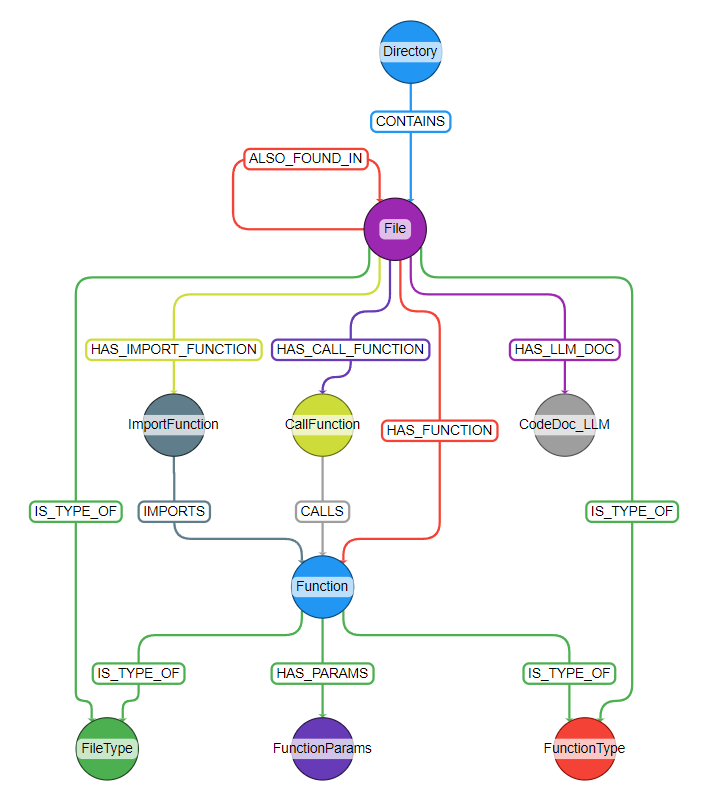

In [21]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\appKGFullSchema.png"

# Display the PNG file
Image(filename=png_path)

###### Code: Gradio chatbot to view files with LLM documentation

In [22]:
# Neo4j graph connection
driver = GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='apprepo')

# Connect to Neo4j
driver.verify_connectivity()
print("Connection established.")

# Fetch all file names from the database
def get_file_names():
    with driver.session() as session:
        result = session.run("MATCH (f:File)-[:HAS_LLM_DOC]-(llm:CodeDoc_LLM)"
                             "RETURN  f.name AS name ORDER BY name")
        return [record["name"] for record in result]

# Fetch llmDoc for a selected file
def get_llm_doc(file_name):
    with driver.session() as session:
        query = """
        MATCH (f:File {name: $file_name})-[:HAS_LLM_DOC]-(llm:CodeDoc_LLM)
        RETURN llm.llmDoc AS llmDoc
        """
        result = session.run(query, file_name=file_name).single()
        return result["llmDoc"] if result else "No documentation found."

# === Gradio app ===
file_names = get_file_names()

with gr.Blocks() as demo:
    gr.Markdown("# LLM Doc Viewer")
    file_dropdown = gr.Dropdown(choices=file_names, label="Select a File")
    output = gr.Markdown()
    submit_button = gr.Button("Get Documentation")

    submit_button.click(fn=get_llm_doc, inputs=file_dropdown, outputs=output)

# Run the app
demo.launch()

# Close driver
driver.close()

Connection established.
* Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


###### Diagram: Gradio chatbot to view LLM explanations already generated

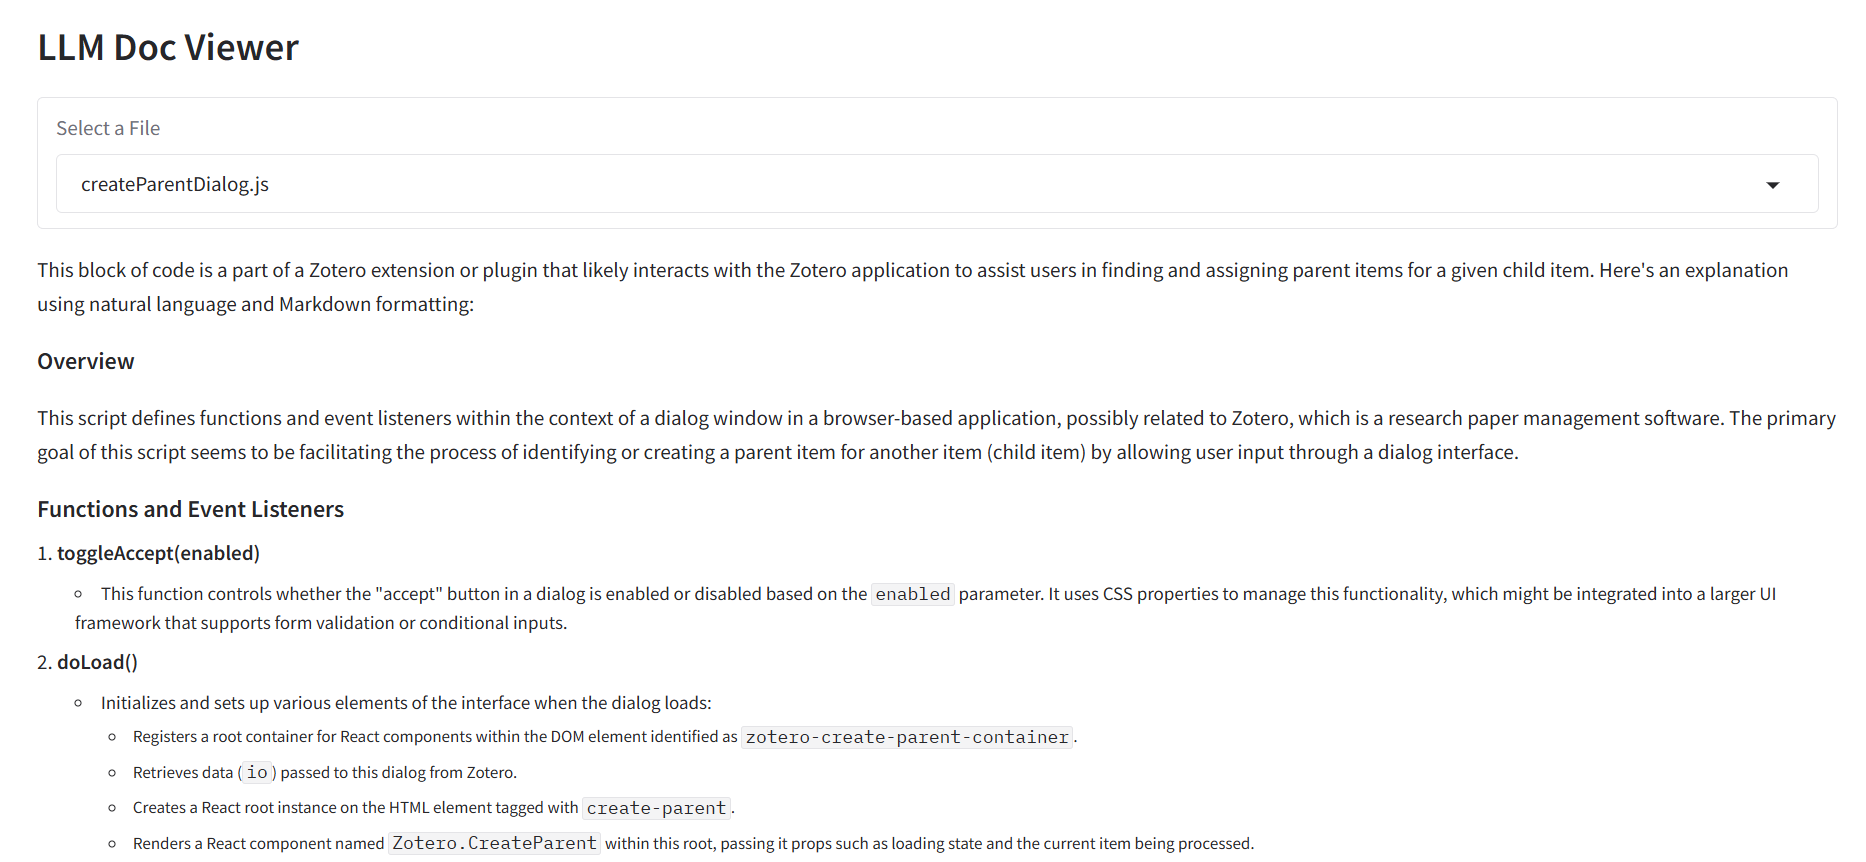

In [3]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\gradioLLMDocViewer.png"

# Display the PNG file
Image(filename=png_path)

#### Key takeaway from creating an App KG

1. Ingesting a repo's directory and file structure into a graph simplifies the subsetting of the codebase


2. Functions and parameters can be extracted by parsing the Abstract Syntax Tree (AST) - no guesswork


3. Lexical search (via Github's Search API) identifies function usage in different file types


4. By querying the graph we can subset the codebase to fit the input token limits of an LLM


5. Natural language explanations by an LLM helps with more detailed AST queries


6. As more questions and use cases arise, we can easily refactor the graph

### 5. Part 3: Building a KG for the business domain layer


#### Working with text

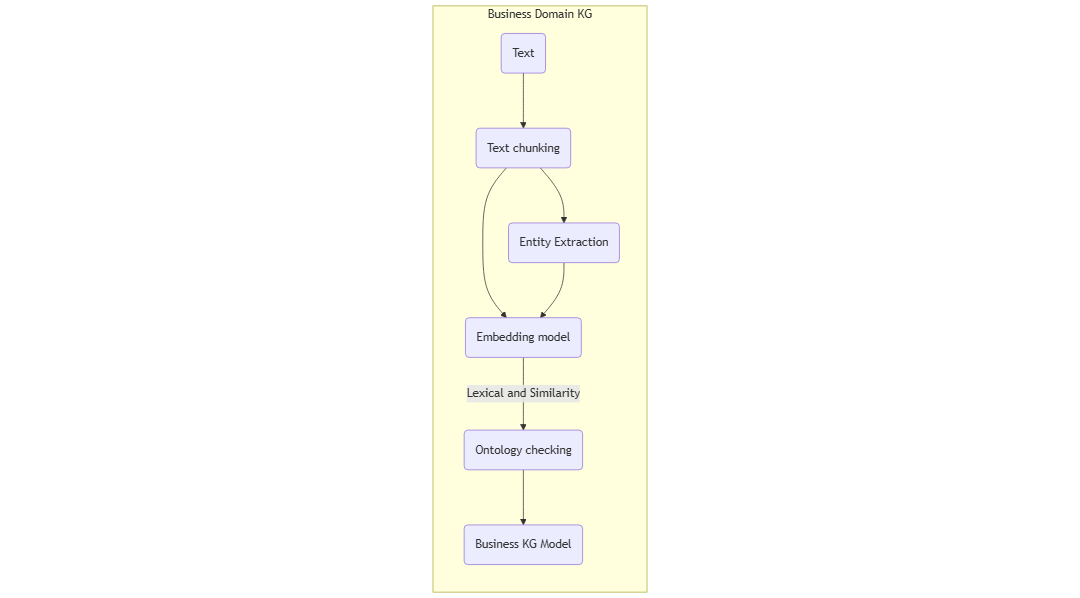

In [23]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\businessKGWorkFlow.png"

# Display the PNG file
Image(filename=png_path)


#### Creating knowledge graphs for the semantic layer:

##### 1. Use ontologies and taxanomies in KG design to add reasoning capabilities

- Ontologies developed by industry - publicly available rdf schemas


- Business data interchange not just within organisations: counterparties and regulators


- FIBO - Financial Industry Business Ontology


- LKIF - Legal Knowledge Interchange Format


- IFRS - International Financial Reporting Standards Accounting Taxonomy


##### 2. Neo4j provides a NeoSemantics plugin to import rdf schemas directly

###### Code: Extracting business concepts from FIBO

- Extracting business concepts from the schema after importing the file `LoansRegulatory.rdf`

In [14]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='fibo') as driver:
    driver.verify_connectivity()
    print("Connection established.")


    # Define a function to run a Cypher query
    def run_cypher_query(query, parameters=None):
        with driver.session(database='fibo') as session:
            result = session.run(query, parameters)
            # Fetch and return the results
            return result.data()


    # All nodes in the graph
    query_node_count = """
    MATCH (n)
    UNWIND labels(n) AS label
    RETURN label, count(n) AS frequency
    ORDER BY frequency DESC;
    """
    result_query_node_count = run_cypher_query(query_node_count)
    df_query_node_count = pd.DataFrame(result_query_node_count)
    print(df_query_node_count)

    print("")

    # All relationships in the graph
    query_relationship_count = """
    CALL db.relationshipTypes() YIELD relationshipType
    RETURN relationshipType, count { MATCH ()-[r]->() WHERE type(r) = relationshipType } AS frequency
    ORDER BY frequency DESC;
    """

    result_query_relationship_count = run_cypher_query(query_relationship_count)
    df_query_relationship_count = pd.DataFrame(result_query_relationship_count)
    print(df_query_relationship_count)

    print("")
    print("Properties of owl__Class")
    # Properties of owl__Class
    query_owl_class_prop = """
    MATCH (c:owl__Class)
    UNWIND keys(properties(c)) AS key
    RETURN elementId(c) AS Node, key AS PropertyKey, properties(c)[key] AS PropertyValue;
    """
    result_owl_class_prop = run_cypher_query(query_owl_class_prop)
    df_query_owl_class_prop = pd.DataFrame(result_owl_class_prop)
    # print(df_query_owl_class_prop)
    df_query_owl_class_prop_filtered = df_query_owl_class_prop[df_query_owl_class_prop['PropertyKey'] == 'rdfs__label']
    print(df_query_owl_class_prop_filtered)

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

# Close the driver
driver.close()

Connection established.
                   label  frequency
0               Resource         75
1             owl__Class         24
2       owl__Restriction         22
3  owl__DatatypeProperty          2
4    owl__ObjectProperty          2
5           _GraphConfig          1
6             _NsPrefDef          1
7          owl__Ontology          1

        relationshipType  frequency
0       rdfs__subClassOf         46
1        owl__onProperty         22
2    owl__someValuesFrom         22
3           owl__imports         10
4            rdfs__range          4
5           rdfs__domain          4
6        owl__versionIRI          1
7  ns2__hasMaturityLevel          1

Properties of owl__Class
                                          Node  PropertyKey  \
1     4:83f01697-f10c-4fa2-b181-6fdc8e1c8980:6  rdfs__label   
4     4:83f01697-f10c-4fa2-b181-6fdc8e1c8980:9  rdfs__label   
8    4:83f01697-f10c-4fa2-b181-6fdc8e1c8980:10  rdfs__label   
10   4:83f01697-f10c-4fa2-b181-6fdc8e1c8980:14  r

GraphWidget(layout=Layout(height='500px', width='100%'))

#### Closing the loop with the Data KG via the App KG

- Business concepts are the tags that are stored in the Data KG

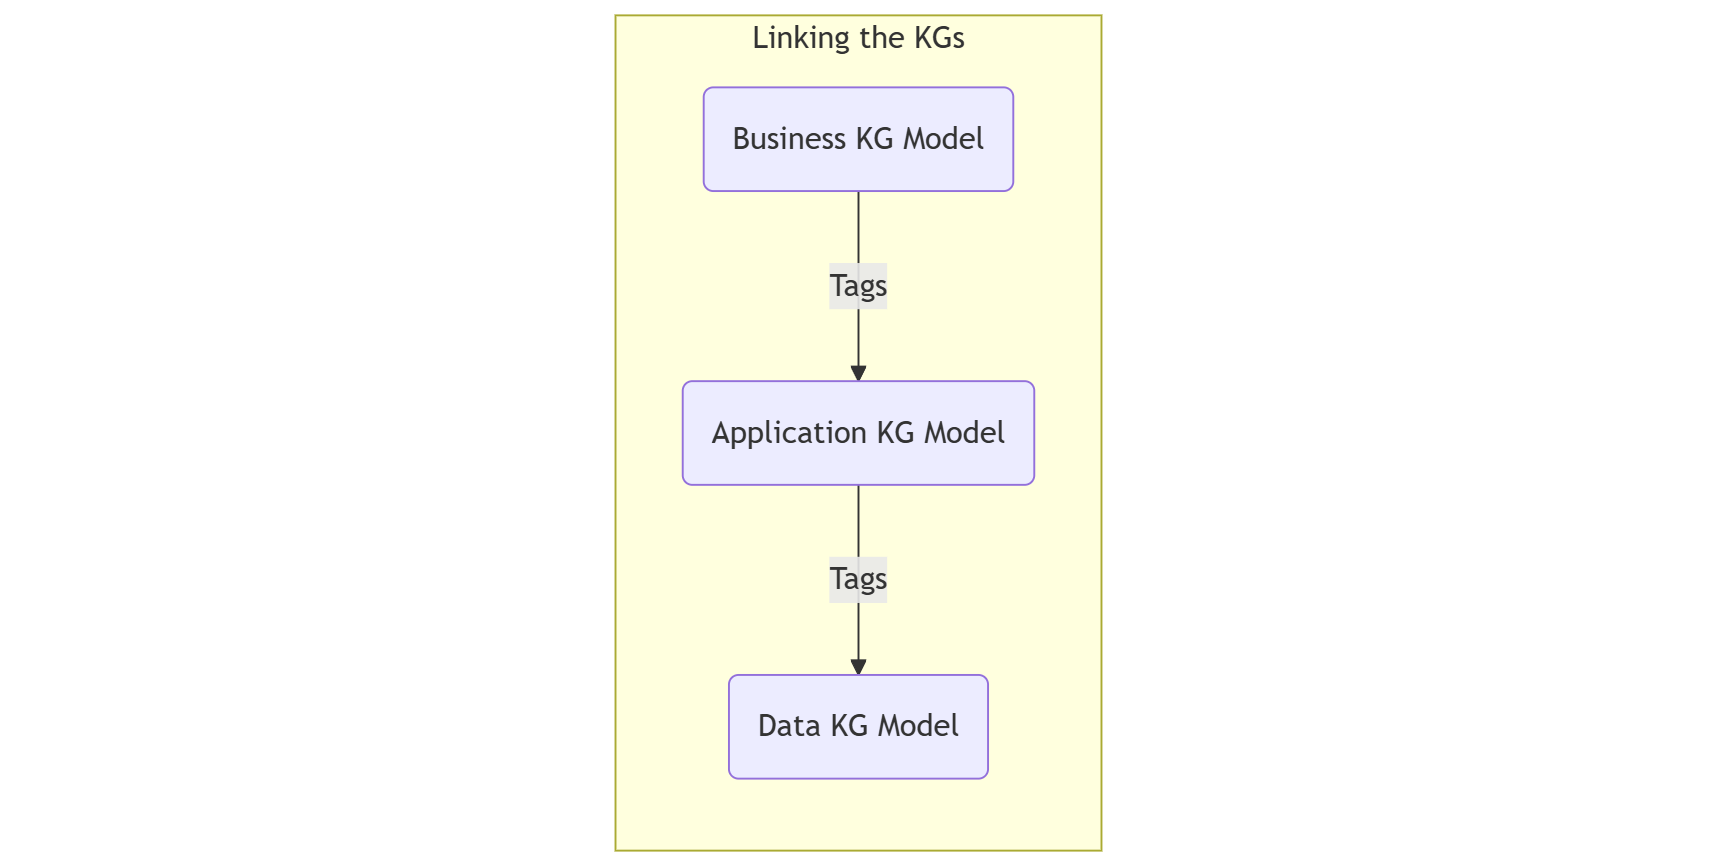

In [13]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\combined.png"

# Display the PNG file
Image(filename=png_path)

### 6. Key takeaways


1. Knowledge graphs help answer questions by connecting data/facts


2. Visualising code as graphs aids traceability - files, functions, params, calls, imports, etc


3. Linking code makes the best use of the AST and lexical search


4. Refactor the graph as questions evolve


5. Linking with business concepts closes the loop


#### Resourses


**Books**

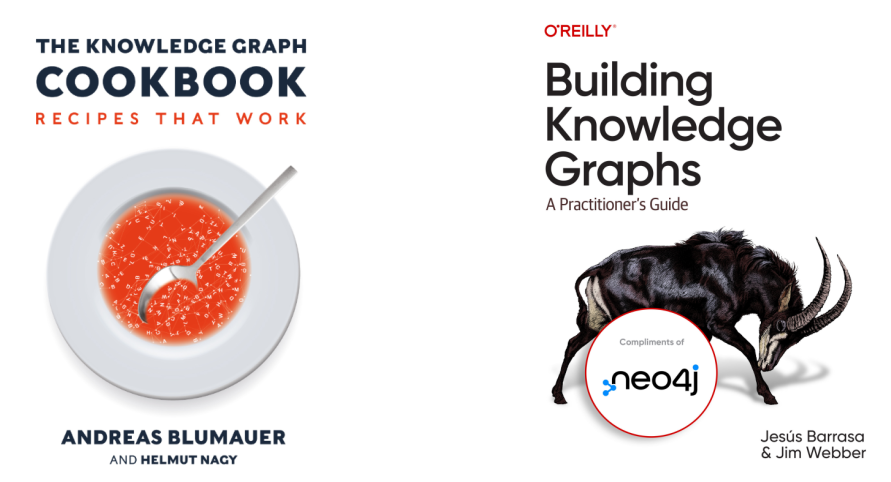

In [15]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\books.png"

# Display the PNG file
Image(filename=png_path)

**Course**

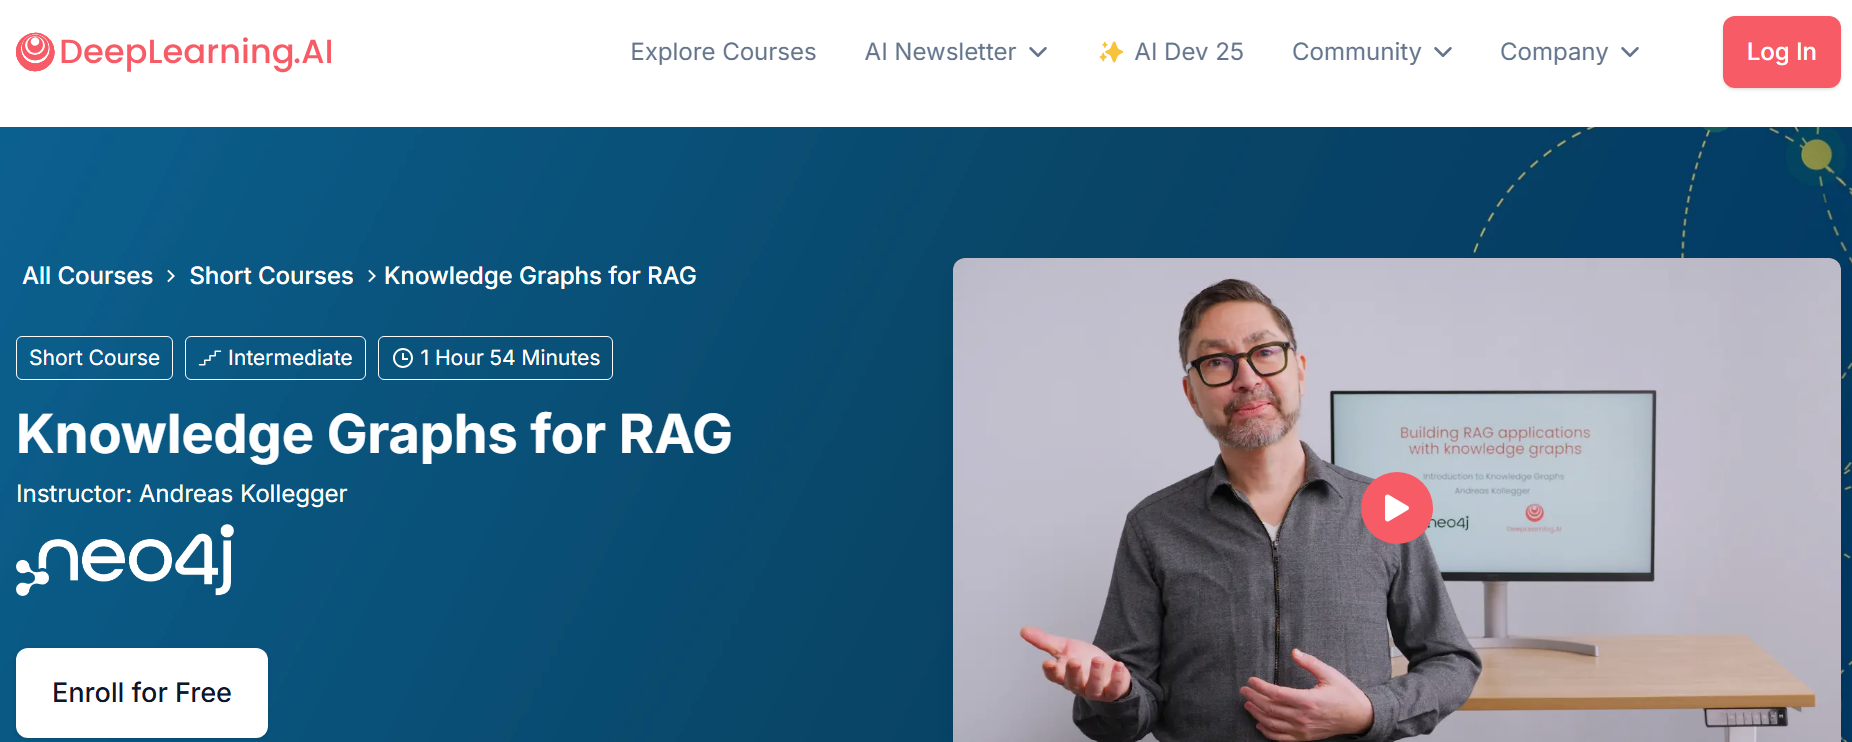

In [16]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams\PNG\neo4JCourse.png"

# Display the PNG file
Image(filename=png_path)